# Import libraries

In [157]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import os
import time
os.environ["CUDA_VISIBLE_DEVICES"]="1"   
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, UpSampling1D, Dropout, BatchNormalization, Input, Layer, Dense,LSTM, AveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Mean, SparseCategoricalAccuracy
from keras import initializers
from keras import metrics
from pandas_datareader import data
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC#Download data from the web via this package
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [149]:
import warnings
warnings.filterwarnings("ignore")
#warnings.filterwarnings("default")

# Traffic data

In [49]:
train = pd.read_csv('train.csv')
EB00=train[(train['x']==0) & (train['y']==0) & (train['direction']=='EB')].loc[:,['time','congestion']]

In [50]:
EB00['time']=pd.to_datetime(EB00['time'])
EB00.set_index('time',inplace=True)

In [51]:
EB00

,congestion
time,
1991-04-01 00:00:00,70
1991-04-01 00:20:00,70
1991-04-01 00:40:00,70
1991-04-01 01:00:00,70
1991-04-01 01:20:00,70
...,...
1991-09-30 10:20:00,43
1991-09-30 10:40:00,47
1991-09-30 11:00:00,40


In [52]:
EB00_train=pd.DataFrame(EB00.iloc[:10000,0])
EB00_test=pd.DataFrame(EB00.iloc[10000:,0])

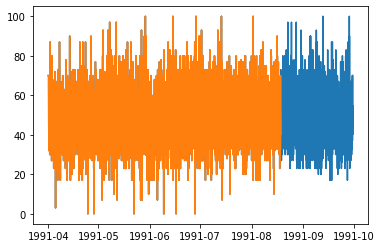

In [55]:
plt.plot(EB00)
plt.plot(EB00_train)

In [59]:
EB00_trainh=EB00_train.resample('h').sum()
EB00_traind=EB00_train.resample('d').sum()
EB00_trainw=EB00_train.resample('w').sum()
EB00_trainm=EB00_train.resample('m').sum()

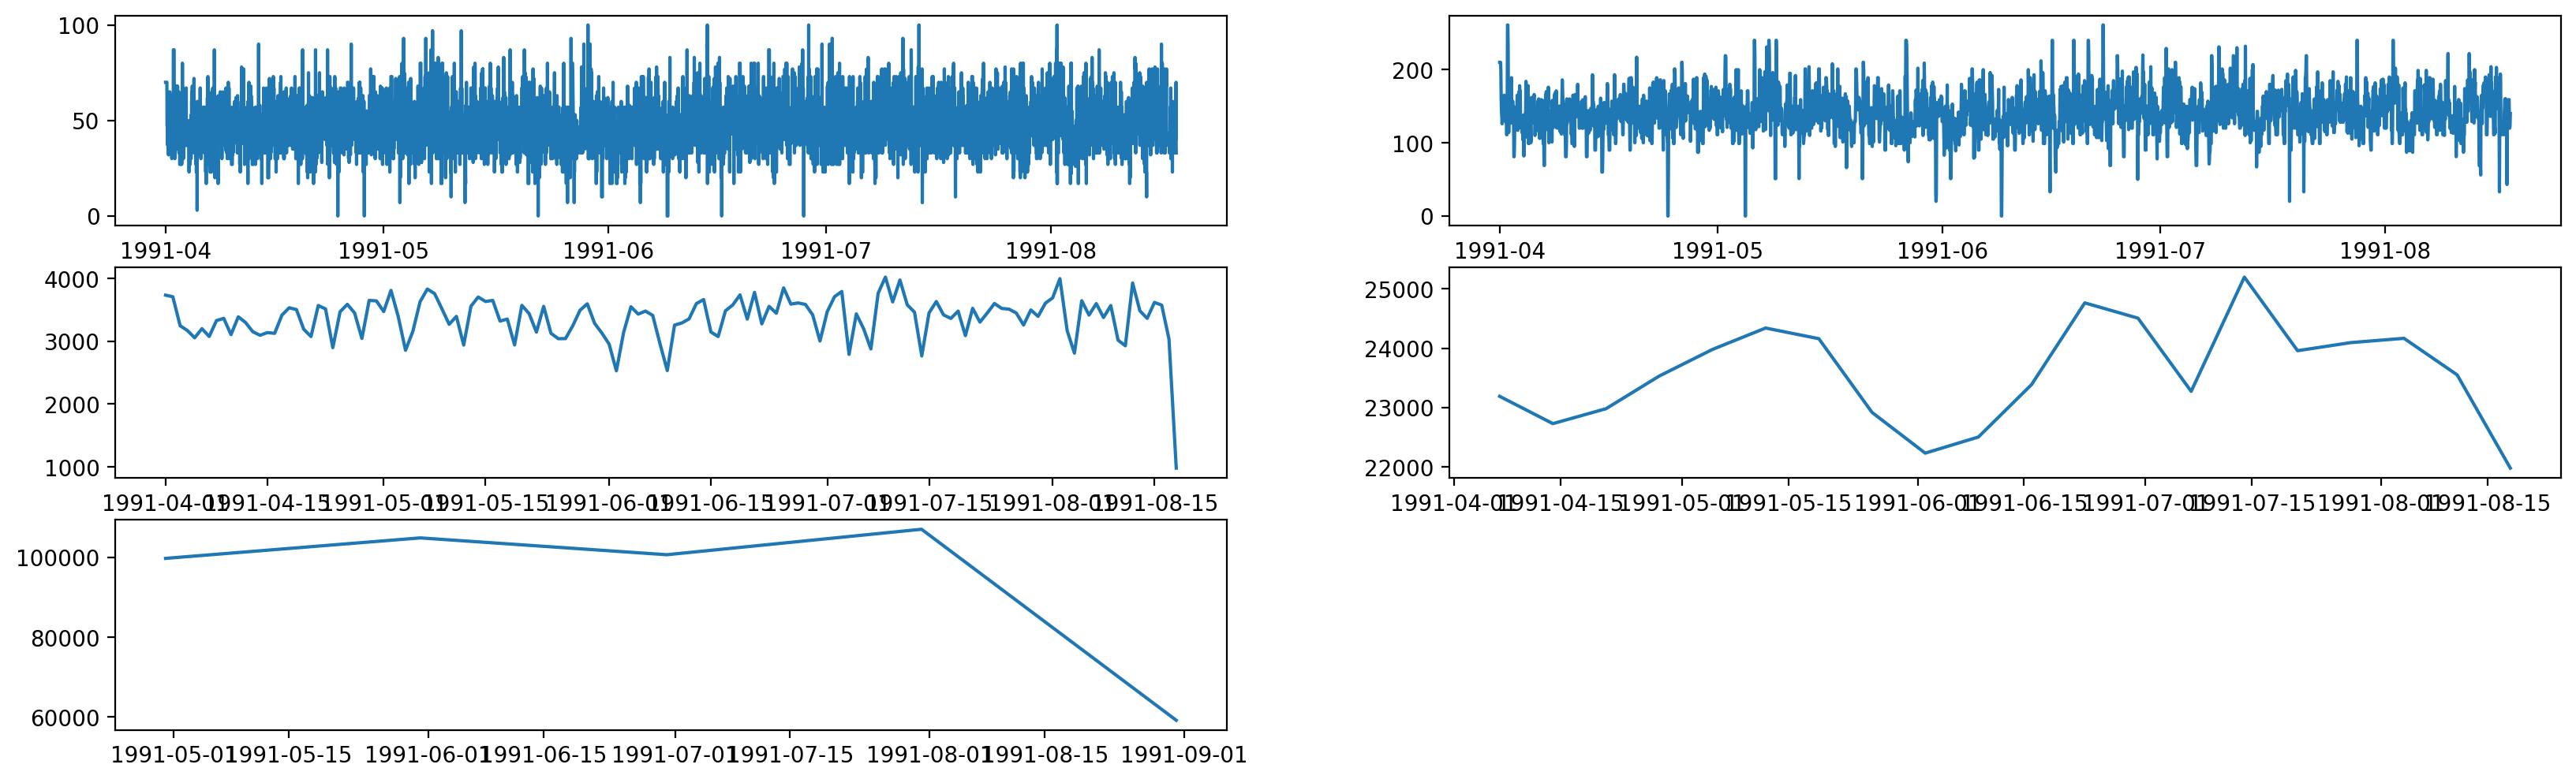

In [60]:
plt.figure(figsize=(20,6),dpi=200)
plt.subplot(3,2,1)
plt.plot(EB00_train)
plt.subplot(3,2,2)
plt.plot(EB00_trainh)
plt.subplot(3,2,3)
plt.plot(EB00_traind)
plt.subplot(3,2,4)
plt.plot(EB00_trainw)
plt.subplot(3,2,5)
plt.plot(EB00_trainm)

In [61]:
EB00_train

,congestion
time,
1991-04-01 00:00:00,70
1991-04-01 00:20:00,70
1991-04-01 00:40:00,70
1991-04-01 01:00:00,70
1991-04-01 01:20:00,70
...,...
1991-08-18 05:20:00,40
1991-08-18 05:40:00,43
1991-08-18 06:00:00,70


In [62]:
EB00_train_T=EB00_train.T
EB00_train_noisy = pd.DataFrame(np.repeat(EB00_train_T.values,100,axis=0), columns=EB00_train_T.columns)

EB00_train_noisy=EB00_train_noisy.iloc[:,52:]
EB00_train_noisy

time,1991-04-01 17:20:00,1991-04-01 17:40:00,1991-04-01 18:00:00,1991-04-01 18:20:00,1991-04-01 18:40:00,1991-04-01 19:00:00,1991-04-01 19:20:00,1991-04-01 19:40:00,1991-04-01 20:00:00,1991-04-01 20:20:00,...,1991-08-18 03:40:00,1991-08-18 04:00:00,1991-08-18 04:20:00,1991-08-18 04:40:00,1991-08-18 05:00:00,1991-08-18 05:20:00,1991-08-18 05:40:00,1991-08-18 06:00:00,1991-08-18 06:20:00,1991-08-18 06:40:00
0,57,40,42,50,42,45,57,45,53,45,...,40,40,40,40,40,40,43,70,37,33
1,57,40,42,50,42,45,57,45,53,45,...,40,40,40,40,40,40,43,70,37,33
2,57,40,42,50,42,45,57,45,53,45,...,40,40,40,40,40,40,43,70,37,33
3,57,40,42,50,42,45,57,45,53,45,...,40,40,40,40,40,40,43,70,37,33
4,57,40,42,50,42,45,57,45,53,45,...,40,40,40,40,40,40,43,70,37,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,57,40,42,50,42,45,57,45,53,45,...,40,40,40,40,40,40,43,70,37,33
96,57,40,42,50,42,45,57,45,53,45,...,40,40,40,40,40,40,43,70,37,33
97,57,40,42,50,42,45,57,45,53,45,...,40,40,40,40,40,40,43,70,37,33
98,57,40,42,50,42,45,57,45,53,45,...,40,40,40,40,40,40,43,70,37,33


In [63]:
EB00_train_T

time,1991-04-01 00:00:00,1991-04-01 00:20:00,1991-04-01 00:40:00,1991-04-01 01:00:00,1991-04-01 01:20:00,1991-04-01 01:40:00,1991-04-01 02:00:00,1991-04-01 02:20:00,1991-04-01 02:40:00,1991-04-01 03:00:00,...,1991-08-18 03:40:00,1991-08-18 04:00:00,1991-08-18 04:20:00,1991-08-18 04:40:00,1991-08-18 05:00:00,1991-08-18 05:20:00,1991-08-18 05:40:00,1991-08-18 06:00:00,1991-08-18 06:20:00,1991-08-18 06:40:00
congestion,70,70,70,70,70,70,70,70,70,70,...,40,40,40,40,40,40,43,70,37,33


In [64]:
EB00_train_pure=pd.DataFrame(columns=EB00_train_T.columns)
for window in range(2,52):#SMA and EMA 
    rolling_mean = EB00_train['congestion'].rolling(window,min_periods=window).mean()
    EB00_train_pure=pd.concat([EB00_train_pure, pd.DataFrame(rolling_mean).T],ignore_index=True)
for window in range(2,52):#SMA and EMA
    ema_mean =  EB00_train['congestion'].ewm(span=window,min_periods=window).mean()
    EB00_train_pure=pd.concat([EB00_train_pure, pd.DataFrame(ema_mean).T],ignore_index=True)
EB00_train_pure=EB00_train_pure.iloc[:,52:]#.shift(periods=1, freq=None, axis=1)
EB00_train_pure

time,1991-04-01 17:20:00,1991-04-01 17:40:00,1991-04-01 18:00:00,1991-04-01 18:20:00,1991-04-01 18:40:00,1991-04-01 19:00:00,1991-04-01 19:20:00,1991-04-01 19:40:00,1991-04-01 20:00:00,1991-04-01 20:20:00,...,1991-08-18 03:40:00,1991-08-18 04:00:00,1991-08-18 04:20:00,1991-08-18 04:40:00,1991-08-18 05:00:00,1991-08-18 05:20:00,1991-08-18 05:40:00,1991-08-18 06:00:00,1991-08-18 06:20:00,1991-08-18 06:40:00
0,60.0,48.5,41.0,46.0,46.0,43.5,51.0,51.0,49.0,49.0,...,40.0,40.0,40.0,40.0,40.0,40.0,41.5,56.5,53.5,35.0
1,54.333333,53.333333,46.333333,44.0,44.666667,45.666667,48.0,49.0,51.666667,47.666667,...,40.0,40.0,40.0,40.0,40.0,40.0,41.0,51.0,50.0,46.666667
2,55.75,50.75,50.5,47.25,43.5,44.75,48.5,47.25,50.0,50.0,...,43.25,40.0,40.0,40.0,40.0,40.0,40.75,48.25,47.5,45.75
3,53.2,52.6,49.0,50.4,46.2,43.8,47.2,47.8,48.4,49.0,...,45.2,42.6,40.0,40.0,40.0,40.0,40.6,46.6,46.0,44.6
4,52.666667,51.0,50.833333,49.166667,49.0,46.0,46.0,46.833333,48.666667,47.833333,...,46.5,44.333333,42.166667,40.0,40.0,40.0,40.5,45.5,45.0,43.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,51.986788,51.431574,50.996737,50.950987,50.541863,50.28958,50.593886,50.341143,50.460855,50.215809,...,46.618147,46.342391,46.078125,45.82487,45.582167,45.349576,45.251677,46.282858,45.896072,45.358736
96,52.013151,51.46507,51.035307,50.988513,50.584025,50.333787,50.631332,50.380935,50.496968,50.254281,...,46.605511,46.335898,46.07729,45.829238,45.59131,45.363093,45.26664,46.276165,45.897546,45.371116
97,52.039471,51.498178,51.073248,51.02546,50.625394,50.377115,50.668215,50.420057,50.532583,50.292145,...,46.593678,46.329931,46.076734,45.833664,45.600318,45.376305,45.281253,46.270003,45.899203,45.383235
98,52.065702,51.530876,51.110557,51.061819,50.665977,50.419575,50.704527,50.458509,50.567689,50.329399,...,46.582644,46.324501,46.076481,45.838188,45.609239,45.389269,45.295572,46.264373,45.901064,45.39514


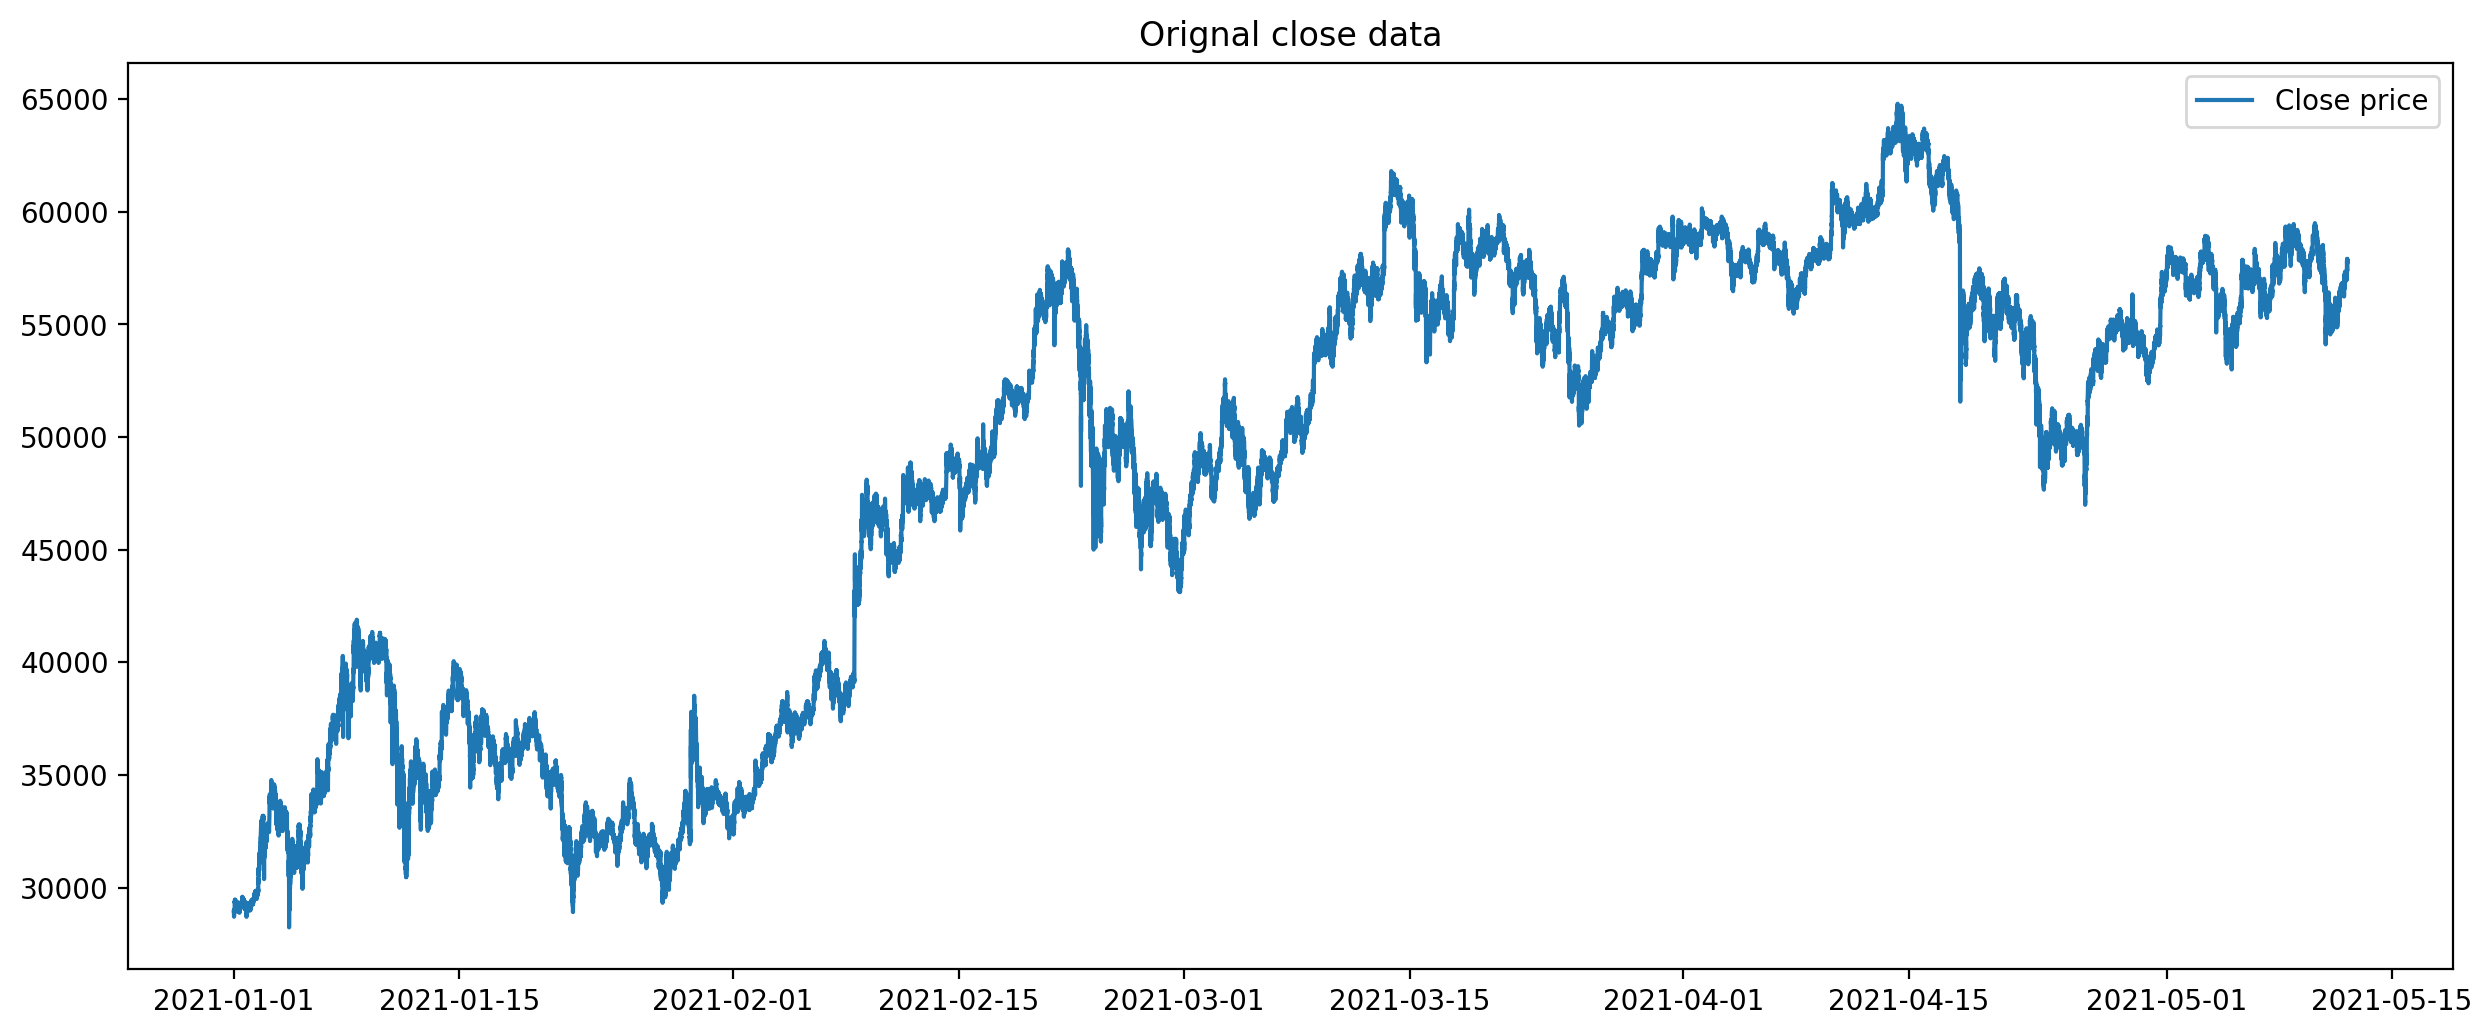

In [113]:
bit = pd.read_csv('bit_c_1m.csv')
bit=bit.iloc[:,1:]
bit['Open Time']=pd.to_datetime(bit['Open Time'])
bit.set_index('Open Time', inplace=True)
bit=bit.T
bit_noisy = pd.DataFrame(np.repeat(bit.values,100,axis=0), columns=bit.columns)

plt.figure(figsize=(15,6),dpi=200)
plt.plot(bit_noisy.iloc[0],label='Close price')
plt.title('Orignal close data')
plt.legend()
plt.show()
bit_noisy=bit_noisy.iloc[:,90:]

In [115]:
bit_T=bit.T
bit_pure=pd.DataFrame(columns=bit.columns)
for window in range(2,52):#SMA and EMA of the day, which using today's price and is the next day's SMA and EMA
    rolling_mean = bit_T['Close'].rolling(window,min_periods=window).mean()
    bit_pure=pd.concat([bit_pure, pd.DataFrame(rolling_mean).T],ignore_index=True)
for window in range(2,52):#SMA and EMA
    ema_mean =  bit_T['Close'].ewm(span=window,min_periods=window).mean()
    bit_pure=pd.concat([bit_pure, pd.DataFrame(ema_mean).T],ignore_index=True)
bit_pure=bit_pure.iloc[:,90:]#.shift(periods=1, freq=None, axis=1)
bit_pure

Open Time,2021-01-01 01:30:00,2021-01-01 01:31:00,2021-01-01 01:32:00,2021-01-01 01:33:00,2021-01-01 01:34:00,2021-01-01 01:35:00,2021-01-01 01:36:00,2021-01-01 01:37:00,2021-01-01 01:38:00,2021-01-01 01:39:00,...,2021-05-12 05:30:00,2021-05-12 05:31:00,2021-05-12 05:32:00,2021-05-12 05:33:00,2021-05-12 05:34:00,2021-05-12 05:35:00,2021-05-12 05:36:00,2021-05-12 05:37:00,2021-05-12 05:38:00,2021-05-12 05:39:00
0,29417.19,29406.23,29377.935,29363.73,29348.415,29360.845,29379.8,29411.425,29446.585,29435.005,...,57674.69,57631.11,57581.94,57549.825,57524.385,57503.195,57483.28,57475.745,57460.45,57450.545
1,29400.95,29399.283333,29401.62,29363.643333,29363.076667,29352.25,29373.79,29394.256667,29430.95,29431.06,...,57674.386667,57647.02,57611.473333,57563.776667,57540.323333,57511.28,57495.96,57478.853333,57467.463333,57457.03
2,29380.8475,29391.58,29397.5625,29384.98,29363.175,29362.2875,29364.1075,29386.135,29413.1925,29423.215,...,57676.465,57653.71,57628.315,57590.4675,57553.1625,57526.51,57503.8325,57489.47,57471.865,57463.145
3,29366.372,29377.372,29391.744,29385.062,29380.338,29362.524,29369.766,29375.92,29402.908,29410.556,...,57673.732,57659.508,57637.408,57608.142,57576.638,57539.544,57517.506,57497.066,57481.756,57467.53
4,29357.745,29365.888333,29379.876667,29382.296667,29381.18,29376.935,29368.716667,29378.666667,29391.6,29402.425,...,57678.908333,57660.056667,57644.956667,57619.081667,57593.671667,57561.376667,57529.868333,57509.588333,57489.371667,57476.495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,29182.771325,29190.45355,29199.031834,29204.805357,29211.462326,29217.753829,29225.458207,29233.825382,29243.813779,29250.415564,...,57684.407634,57680.543982,57676.02965,57669.838831,57663.650546,57656.20969,57648.929703,57641.474299,57633.533703,57625.894382
96,29179.818901,29187.48055,29196.021778,29201.81201,29208.467929,29214.764913,29222.447355,29230.780456,29240.704836,29247.309422,...,57681.226855,57677.571882,57673.270989,57667.319111,57661.359964,57654.164455,57647.116518,57639.887273,57632.173506,57624.745608
97,29176.945183,29184.584835,29193.088349,29198.892305,29205.54506,29211.845195,29219.504639,29227.803162,29237.664328,29244.269588,...,57678.016776,57674.563305,57670.468773,57664.748022,57659.010901,57652.053265,57645.230735,57638.221505,57630.728645,57623.507099
98,29174.147973,29181.76438,29190.229646,29196.044593,29202.692267,29208.993426,29216.628928,29224.89245,29234.691207,29241.295188,...,57674.781748,57671.522856,57667.627842,57662.130672,57656.608685,57649.881677,57643.278082,57636.482863,57629.205104,57622.184904


## Fit models(ltsm/cnn)

## MinMaxScaler(GSPC)

In [67]:
mm_t = MinMaxScaler()
noise_mm = mm_t.fit_transform(EB00_train_noisy.T).T
pure_mm=mm_t.transform(EB00_train_pure.T).T
print(noise_mm.shape)
print(pure_mm.shape)

(100, 9948)
(100, 9948)


In [68]:
train_pure_mm=np.reshape(prue_mm,(len(pure_mm), len(pure_mm[0]), 1))
train_mm=np.reshape(noise_mm, (len(noise_mm), len(noise_mm[0]), 1))

# convert list to numpy array
X_train_mm = np.asarray(train_mm)
Y_train_mm = np.asarray(train_pure_mm)
X_train_mm, X_val_mm, Y_train_mm, Y_val_mm = train_test_split(X_train_mm, Y_train_mm, test_size=0.2,random_state=0)

In [69]:

EB00_train_test=EB00_train[52:]

In [70]:
EB00_train_test

,congestion
time,
1991-04-01 17:20:00,57
1991-04-01 17:40:00,40
1991-04-01 18:00:00,42
1991-04-01 18:20:00,50
1991-04-01 18:40:00,42
...,...
1991-08-18 05:20:00,40
1991-08-18 05:40:00,43
1991-08-18 06:00:00,70


In [13]:
def set_model_LSTM():
    model = Sequential()
    #model.add(Conv1D(64, kernel_size=2, activation='tanh', padding='same',input_shape=(None, 1)))
    model.add(LSTM(8, input_shape=(None, 1),activation='tanh', return_sequences = True))
    model.add(LSTM(4, activation='tanh',return_sequences = True))
    #model.add(AveragePooling1D(2, padding='same'))
    model.add(LSTM(4, activation='tanh',return_sequences = True))
    model.add(LSTM(8, activation='tanh',return_sequences = True))
    #model.add(UpSampling1D(2))
    #model.add(Dense(1,activation='tanh'))#
    model.add(Conv1D(1,kernel_size=2,activation='relu', padding='same'))
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mae'])
    return model
modelen_LSTM = set_model_LSTM()
modelen_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 8)           320       
                                                                 
 lstm_1 (LSTM)               (None, None, 4)           208       
                                                                 
 lstm_2 (LSTM)               (None, None, 4)           144       
                                                                 
 lstm_3 (LSTM)               (None, None, 8)           416       
                                                                 
 conv1d_5 (Conv1D)           (None, None, 1)           17        
                                                                 
Total params: 1,105
Trainable params: 1,105
Non-trainable params: 0
_________________________________________________________________


In [14]:
callback = EarlyStopping(monitor='loss', patience=10)
history_LSTM = modelen_LSTM.fit(X_train_mm, Y_train_mm, validation_data = (X_val_mm, Y_val_mm), epochs=800, batch_size=32, verbose=1, callbacks=[callback])

Epoch 1/800
3/3 [==============================] - 7s 896ms/step - loss: 0.3136 - mae: 0.4874 - val_loss: 0.3019 - val_mae: 0.4751
Epoch 2/800
3/3 [==============================] - 1s 382ms/step - loss: 0.2920 - mae: 0.4651 - val_loss: 0.2678 - val_mae: 0.4424
Epoch 3/800
3/3 [==============================] - 1s 382ms/step - loss: 0.2563 - mae: 0.4304 - val_loss: 0.2280 - val_mae: 0.4020
Epoch 4/800
3/3 [==============================] - 1s 390ms/step - loss: 0.2154 - mae: 0.3880 - val_loss: 0.1842 - val_mae: 0.3534
Epoch 5/800
3/3 [==============================] - 1s 430ms/step - loss: 0.1713 - mae: 0.3387 - val_loss: 0.1393 - val_mae: 0.3028
Epoch 6/800
3/3 [==============================] - 1s 396ms/step - loss: 0.1272 - mae: 0.2888 - val_loss: 0.0975 - val_mae: 0.2533
Epoch 7/800
3/3 [==============================] - 1s 400ms/step - loss: 0.0875 - mae: 0.2425 - val_loss: 0.0643 - val_mae: 0.2164
Epoch 8/800
3/3 [==============================] - 1s 390ms/step - loss: 0.0581 - m

In [49]:
modelen_LSTM.save_weights('model_weights_LSTM.h5', overwrite=True) 

In [19]:
modelen_LSTM.load_weights('model_weights_LSTM.h5') 

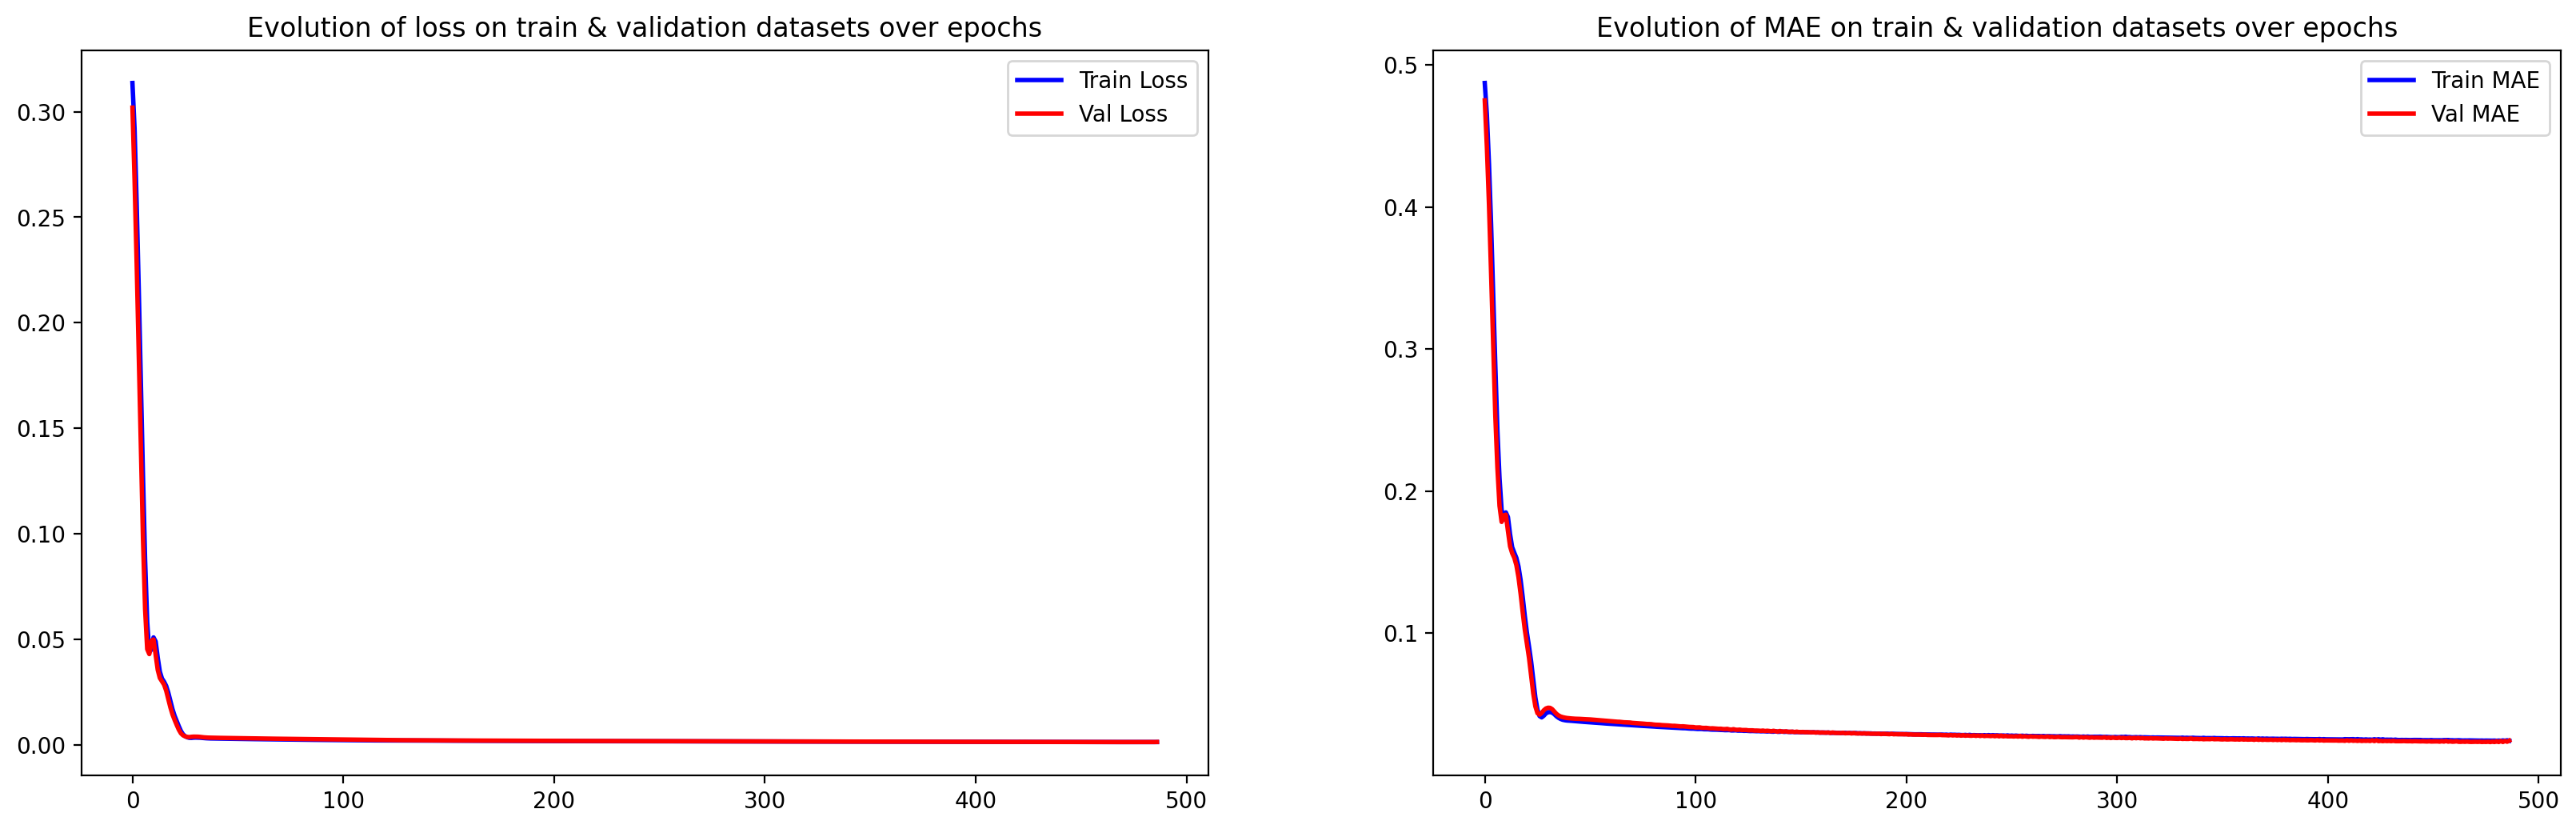

In [15]:
# Check how loss & mae went down
epoch_loss = history_LSTM.history['loss']
epoch_val_loss = history_LSTM.history['val_loss']
epoch_mae = history_LSTM.history['mae']
epoch_val_mae = history_LSTM.history['val_mae']

plt.figure(figsize=(20,6),dpi=200)
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

1/1 [==============================] - 1s 1s/step


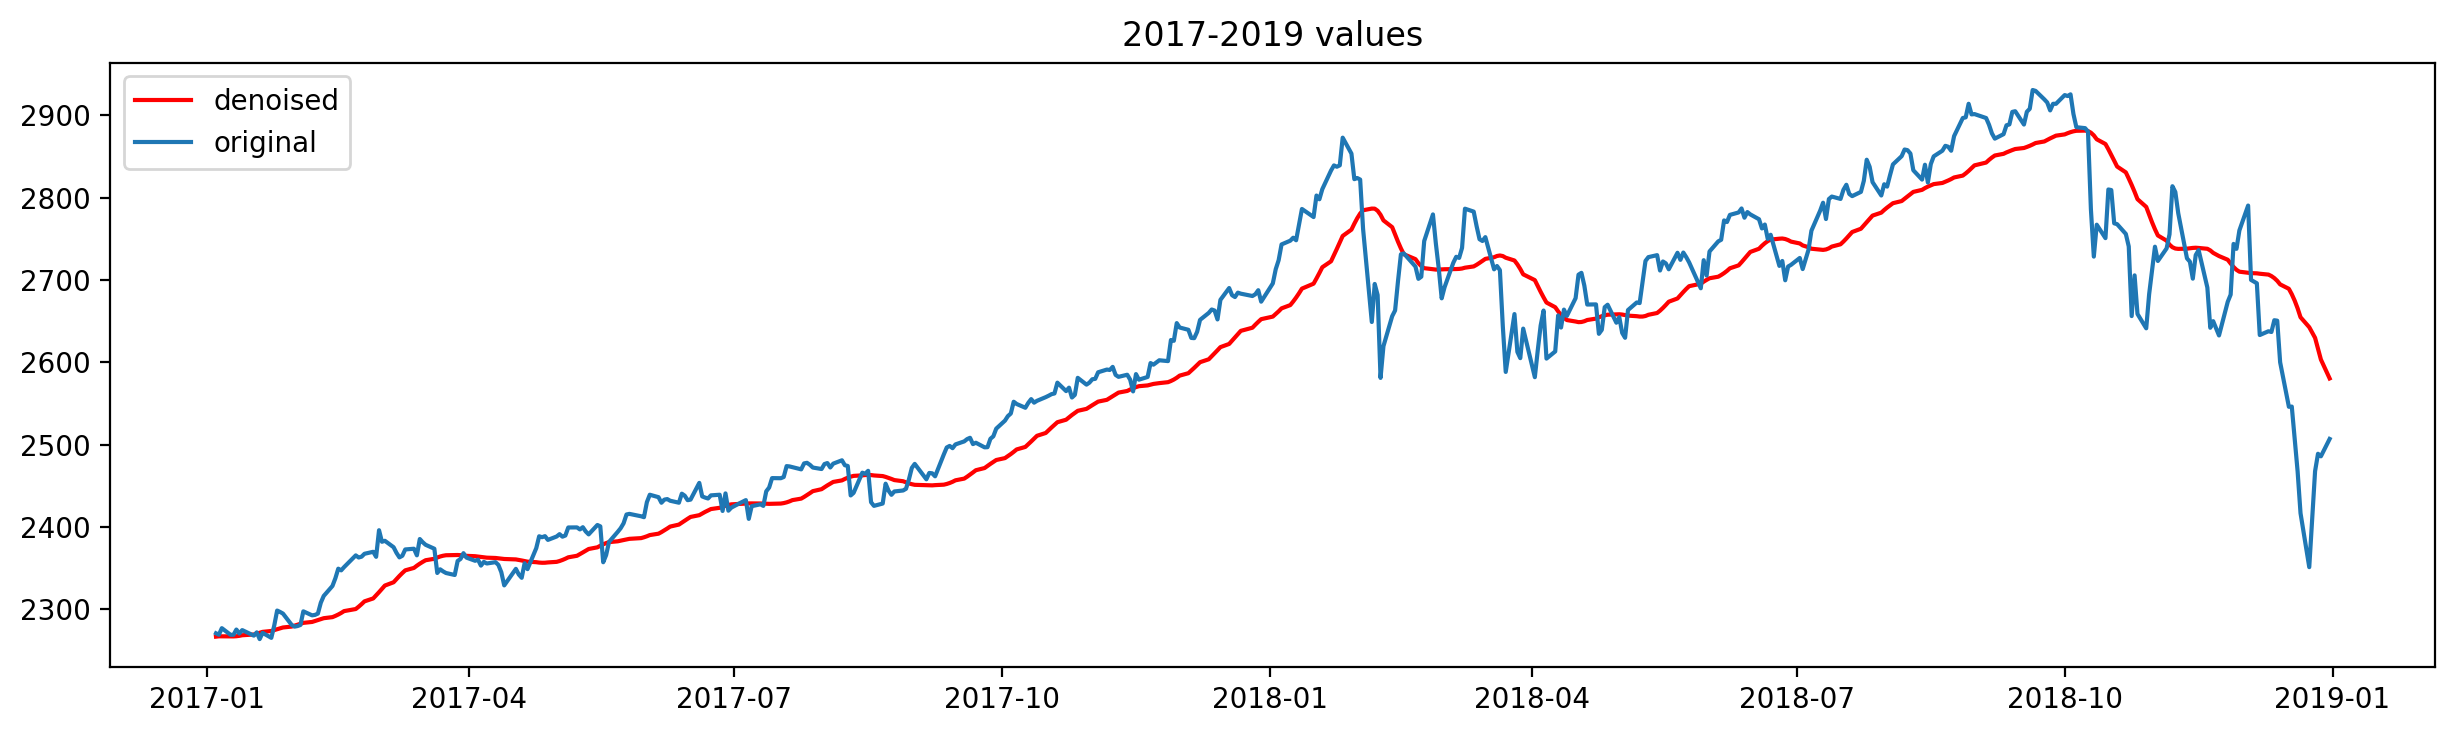

In [16]:
mm_t = MinMaxScaler()
noise_mm_T=mm_t.fit_transform(GSPC_test)
Y_test_mm_lstm = modelen_LSTM.predict(noise_mm_T.T, batch_size=16)
Y_test_mm_lstm=Y_test_mm_lstm.reshape((len(GSPC_test),1))
pure_mm_lstm = mm_t.inverse_transform(Y_test_mm_lstm)
pure_mm_lstm=pd.DataFrame(pure_mm_lstm,columns=['Close'],index=GSPC_test.index)
plt.figure(figsize=(15,4),dpi=200)
plt.plot(pure_mm_lstm,'r')
plt.plot(GSPC_test)
plt.title('2017-2019 values')
plt.legend(['denoised', 'original'], loc='upper left')

## CNN

In [452]:
def set_model_encoding_mm():
    model = Sequential()
    model.add(Conv1D(256, kernel_size=2, activation='tanh', padding='same',input_shape=(None, 1)))
    model.add(Conv1D(64, kernel_size=2,activation='tanh',padding='same'))
    model.add(Conv1D(64, kernel_size=2, activation='tanh', padding='same'))
    model.add(Conv1D(256, kernel_size=2,activation='tanh',padding='same'))
    model.add(Conv1D(1,kernel_size=1,activation='sigmoid', padding='same'))
    model.compile(optimizer='adam' , loss='mae', metrics=['mae'])
    
    return model
modelen_mm = set_model_encoding_mm()
modelen_mm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, None, 256)         768       
                                                                 
 conv1d_16 (Conv1D)          (None, None, 64)          32832     
                                                                 
 conv1d_17 (Conv1D)          (None, None, 64)          8256      
                                                                 
 conv1d_18 (Conv1D)          (None, None, 256)         33024     
                                                                 
 conv1d_19 (Conv1D)          (None, None, 1)           257       
                                                                 
Total params: 75,137
Trainable params: 75,137
Non-trainable params: 0
_________________________________________________________________


In [453]:
callback = EarlyStopping(monitor='loss', patience=10)
history_mm = modelen_mm.fit(X_train_mm, Y_train_mm, validation_data = (X_val_mm, Y_val_mm), epochs=400, batch_size=32, verbose=1, callbacks=[callback])

Epoch 1/400
3/3 [==============================] - 4s 1s/step - loss: 0.0537 - mae: 0.0537 - val_loss: 0.0490 - val_mae: 0.0490
Epoch 2/400
3/3 [==============================] - 3s 860ms/step - loss: 0.0477 - mae: 0.0477 - val_loss: 0.0493 - val_mae: 0.0493
Epoch 3/400
3/3 [==============================] - 3s 804ms/step - loss: 0.0468 - mae: 0.0468 - val_loss: 0.0496 - val_mae: 0.0496
Epoch 4/400
3/3 [==============================] - 3s 811ms/step - loss: 0.0469 - mae: 0.0469 - val_loss: 0.0480 - val_mae: 0.0480
Epoch 5/400
3/3 [==============================] - 3s 808ms/step - loss: 0.0460 - mae: 0.0460 - val_loss: 0.0479 - val_mae: 0.0479
Epoch 6/400
3/3 [==============================] - 3s 818ms/step - loss: 0.0456 - mae: 0.0456 - val_loss: 0.0473 - val_mae: 0.0473
Epoch 7/400
3/3 [==============================] - 3s 843ms/step - loss: 0.0452 - mae: 0.0452 - val_loss: 0.0468 - val_mae: 0.0468
Epoch 8/400
3/3 [==============================] - 3s 870ms/step - loss: 0.0445 - mae:

In [254]:
modelen_mm.save_weights('model_weights_mm.h5', overwrite=True)  

In [255]:
modelen_mm.load_weights('model_weights_mm.h5') 

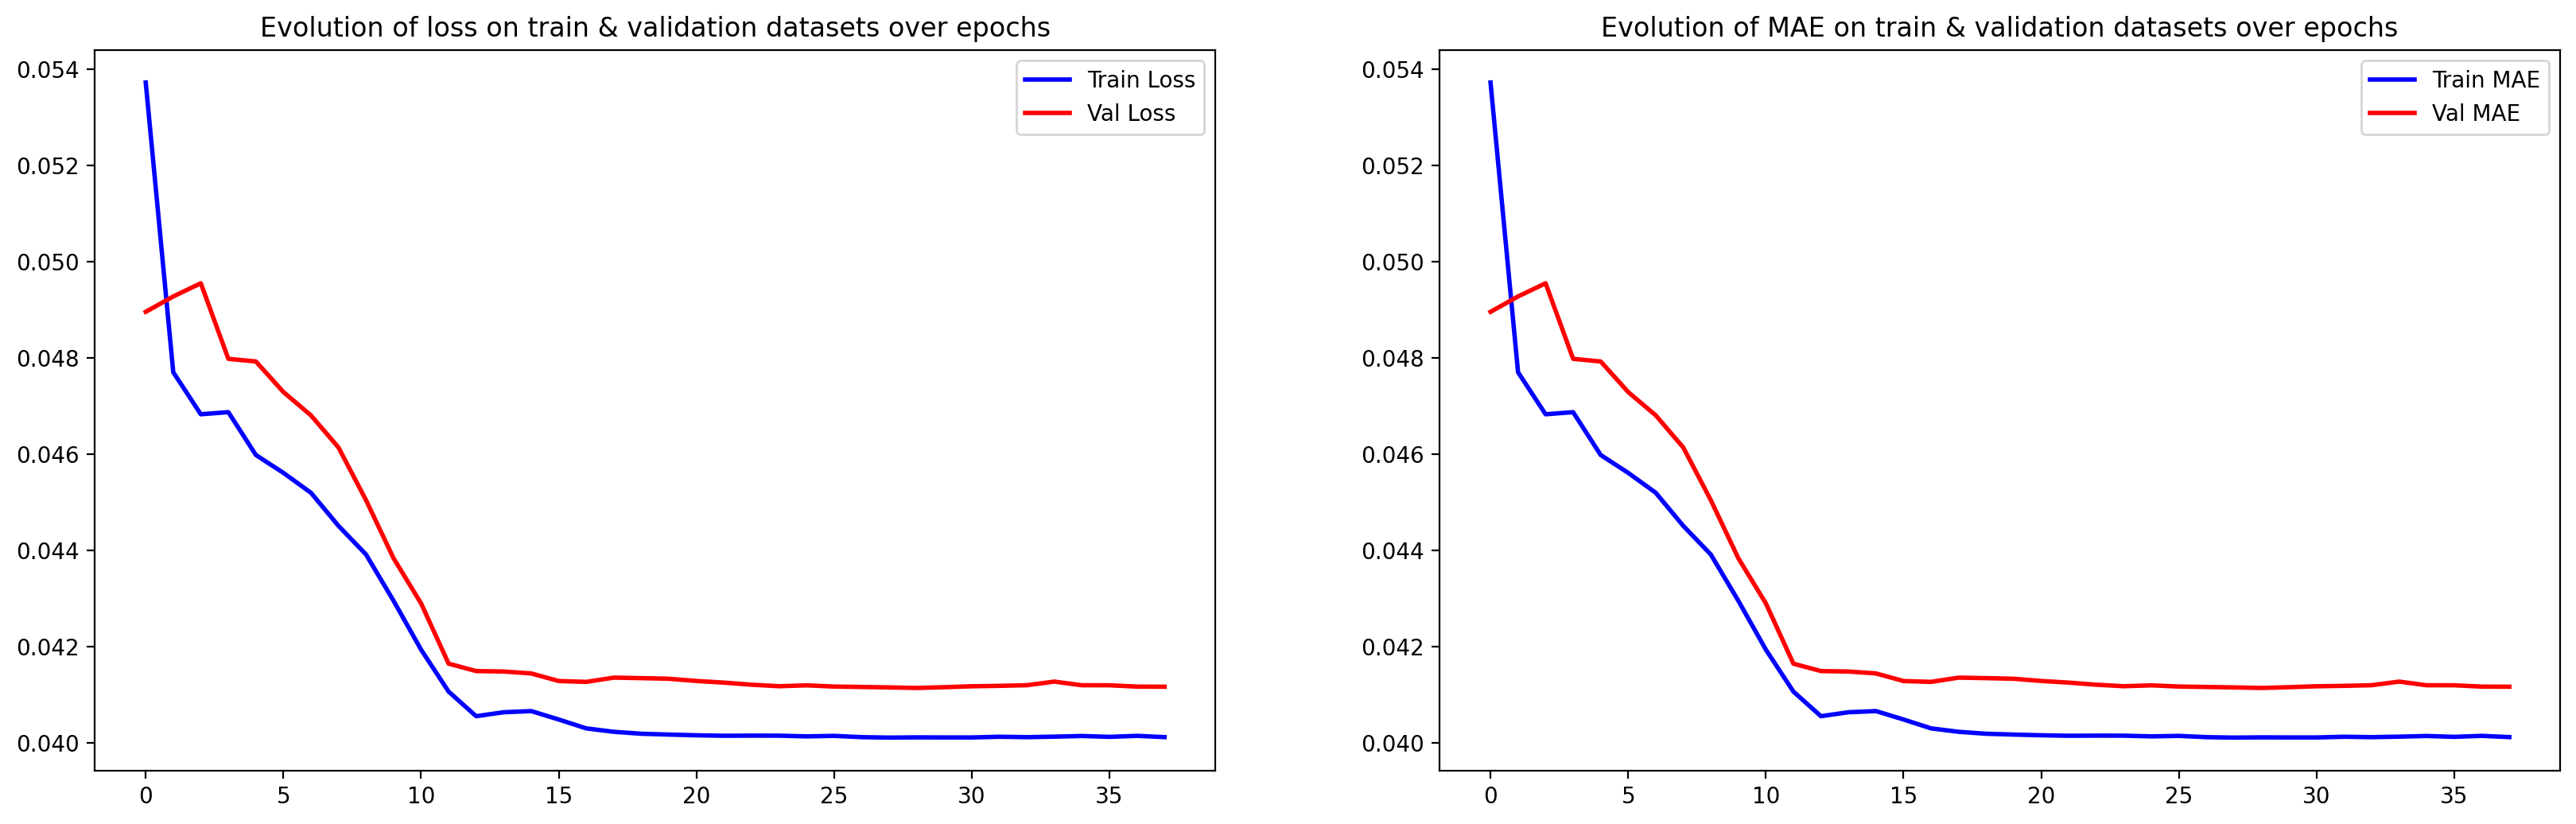

In [454]:
# Check how loss & mae went down
epoch_loss = history_mm.history['loss']
epoch_val_loss = history_mm.history['val_loss']
epoch_mae = history_mm.history['mae']
epoch_val_mae = history_mm.history['val_mae']

plt.figure(figsize=(20,6),dpi=200)
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

1/1 [==============================] - 0s 64ms/step


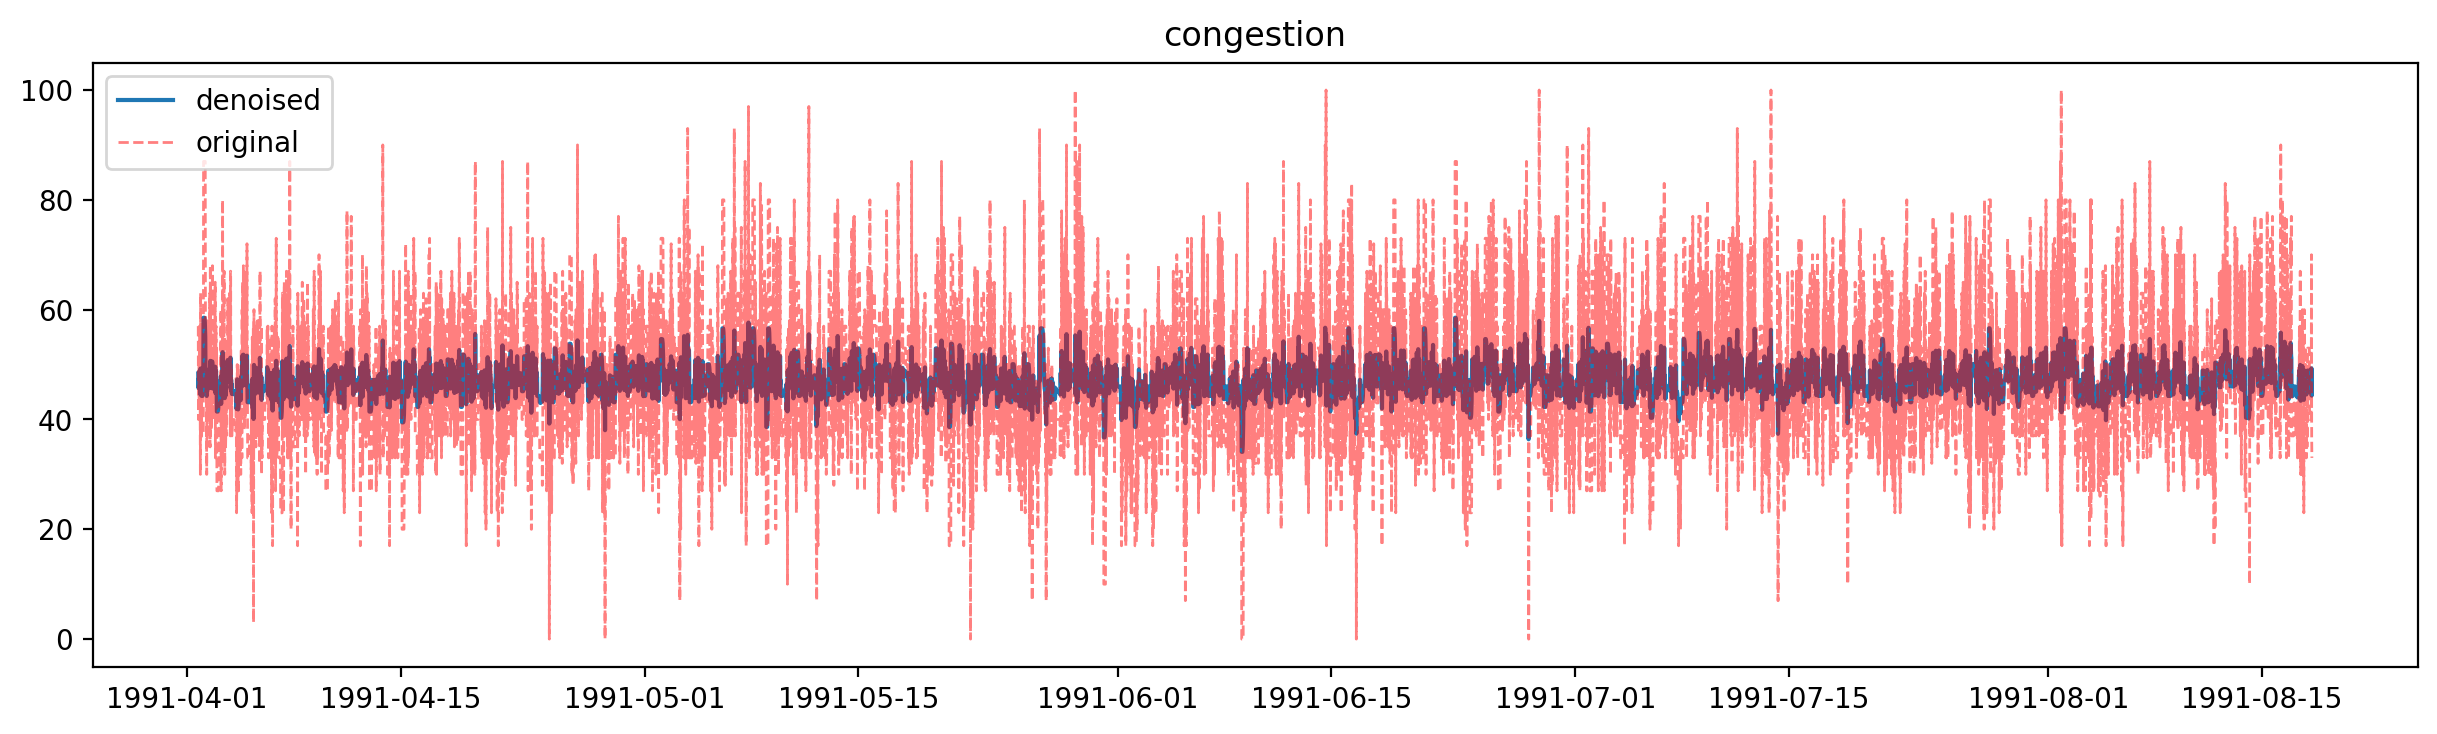

In [455]:
mm_t = MinMaxScaler()
noise_mm_T=mm_t.fit_transform(EB00_train_test)
Y_test_mm_cnn = modelen_mm.predict(noise_mm_T.T)
Y_test_mm_cnn=Y_test_mm_cnn.reshape((len(EB00_train_test),1))
pure_mm_cnn = mm_t.inverse_transform(Y_test_mm_cnn)
pure_mm_cnn=pd.DataFrame(pure_mm_cnn,columns=['congestion'],index=EB00_train_test.index)
plt.figure(figsize=(15,4),dpi=200)
plt.plot(pure_mm_cnn)
plt.plot(EB00_train_test,color='r',linestyle='--',linewidth=1,alpha=0.5)
plt.title('congestion')
plt.legend(['denoised', 'original'], loc='upper left')

In [456]:
original=EB00_train_test

In [457]:
def features(dataset):
    ret_dataset=pd.DataFrame()
    for i in range(1,52,1):
        window = i
        # Volatility
        ret_dataset[str('volatility'+str(i))] = dataset['congestion'].rolling(window=window).std().shift(1)
        ret_dataset[str('ma'+str(i))] = dataset['congestion'].rolling(window=window).mean().shift(1)
        ret_dataset[str('evolatility'+str(i))] = dataset['congestion'].ewm(span=window).std().shift(1)
        ret_dataset[str('ema'+str(i))] = dataset['congestion'].ewm(span=window).mean().shift(1)
        ret_dataset[str('lag'+str(i))] = dataset['congestion'].shift(i)



    return ret_dataset

In [458]:
pure_mm_cnn_fea=features(pure_mm_cnn)
#pure_mm_cnn_fea['congestion']=pure_mm_cnn['congestion']
pure_mm_cnn_fea=pure_mm_cnn_fea.iloc[51:]
X_train, X_test, Y_train, Y_test = train_test_split(pure_mm_cnn_fea, pure_mm_cnn.iloc[51:], test_size=0.2)

model = xgb.XGBRegressor(max_depth=8,learning_rate=0.1,n_estimators=300,eval_metric='mae',verbosity=1)
his=model.fit(X_train,Y_train)

test_predict=model.predict(X_test)
train_predict = model.predict(X_train)

In [459]:
msetest=mean_squared_error(Y_test,test_predict)
msetrain=mean_squared_error(Y_train,train_predict)

In [460]:
print(msetest)
print(msetrain)

3.5983925
0.05620222


In [461]:
pure_mm_cnn_fea=features(pure_mm_cnn)
#pure_mm_cnn_fea['congestion']=pure_mm_cnn['congestion']
pure_mm_cnn_fea=pure_mm_cnn_fea.iloc[51:]
X_train, X_test, Y_train, Y_test = train_test_split(pure_mm_cnn_fea, original.iloc[51:], test_size=0.2)

model = xgb.XGBRegressor(max_depth=16,learning_rate=0.1,n_estimators=200,eval_metric='mae',verbosity=1)
his=model.fit(X_train,Y_train)

test_predict=model.predict(X_test)
train_predict = model.predict(X_train)

msetest=mean_squared_error(Y_test,test_predict)
msetrain=mean_squared_error(Y_train,train_predict)

print(msetest)
print(msetrain)

101.2188126653598
0.00021937122870467146


In [462]:
original_fea=features(original)
original_fea=original_fea.iloc[51:]
X_train, X_test, Y_train, Y_test = train_test_split(original_fea, original.iloc[51:], test_size=0.2)

model = xgb.XGBRegressor(max_depth=16,learning_rate=0.1,n_estimators=200,eval_metric='mae',verbosity=1)
his=model.fit(X_train,Y_train)

test_predict=model.predict(X_test)
train_predict = model.predict(X_train)

msetest=mean_squared_error(Y_test,test_predict)
msetrain=mean_squared_error(Y_train,train_predict)

print(msetest)
print(msetrain)

129.018058133387
0.0005170413277007151


1/1 [==============================] - 0s 92ms/step


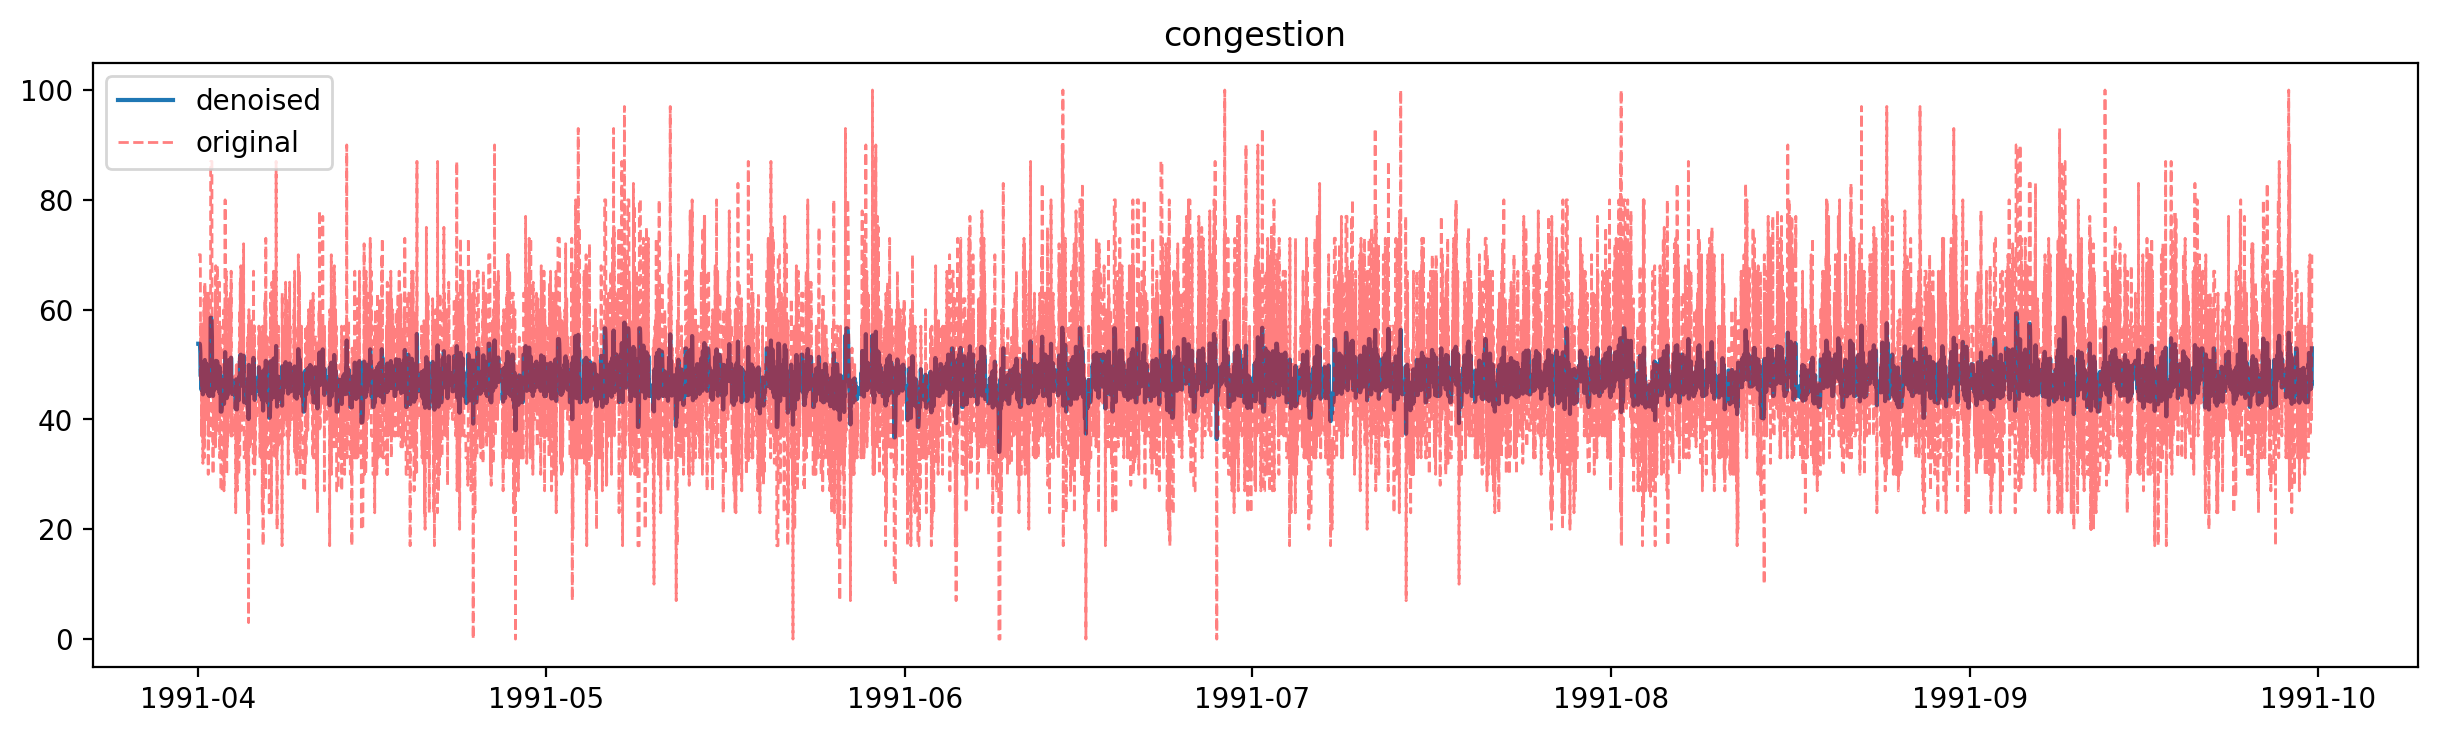

In [463]:
mm_t = MinMaxScaler()
EB00_mm_T=mm_t.fit_transform(EB00)
EB00_mm = modelen_mm.predict(EB00_mm_T.T)
EB00_mm=EB00_mm.reshape((len(EB00),1))
pure_mm = mm_t.inverse_transform(EB00_mm)
pure_mm=pd.DataFrame(pure_mm,columns=['congestion'],index=EB00.index)
plt.figure(figsize=(15,4),dpi=200)
plt.plot(pure_mm)
plt.plot(EB00,color='r',linestyle='--',linewidth=1,alpha=0.5)
plt.title('congestion')
plt.legend(['denoised', 'original'], loc='upper left')

In [464]:
pure_mm_fea=features(pure_mm)

In [465]:
pure_mm_train_fea=pd.DataFrame(pure_mm_fea.iloc[51:10000,:])
pure_mm_test_fea=pd.DataFrame(pure_mm_fea.iloc[10000:,:])

In [466]:
EB00_fea=features(EB00)

In [467]:
EB00_train_fea=pd.DataFrame(EB00_fea.iloc[51:10000,:])
EB00_test_fea=pd.DataFrame(EB00_fea.iloc[10000:,:])

In [468]:
EB00_train=pd.DataFrame(EB00.iloc[51:10000,0])
EB00_test=pd.DataFrame(EB00.iloc[10000:,0])

In [476]:

model = xgb.XGBRegressor(max_depth=5,
                        learning_rate=0.1,
                        n_estimators=500,
                        gamma=0,
                        min_child_weight=1,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        colsample_bylevel=1,
                        reg_alpha=0,
                        reg_lambda=1)
model.fit(pure_mm_train_fea,EB00_train)

test_predict=model.predict(pure_mm_test_fea)
train_predict = model.predict(pure_mm_train_fea)

msetest=mean_squared_error(EB00_test,test_predict)
msetrain=mean_squared_error(EB00_train,train_predict)

print(msetest)
print(msetrain)

101.33658393917128
14.156359900497762


In [477]:
pre_te=pd.DataFrame(test_predict,index=pure_mm_test_fea.index)
pre_tr=pd.DataFrame(train_predict,index=pure_mm_train_fea.index)

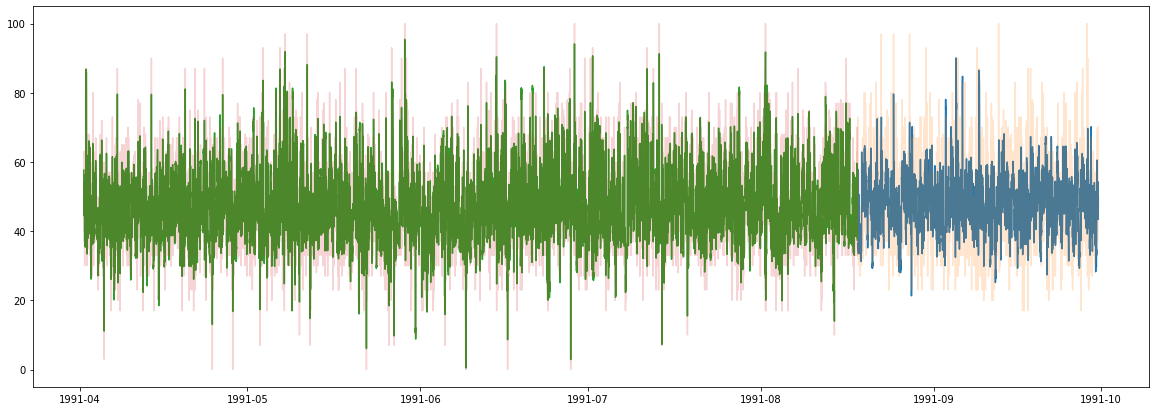

In [478]:
plt.figure(figsize=(20,7))
plt.plot(pre_te)
plt.plot(EB00_test,alpha=0.2)
plt.plot(pre_tr)
plt.plot(EB00_train,alpha=0.2)

In [479]:


model = xgb.XGBRegressor(max_depth=5,
                        learning_rate=0.1,
                        n_estimators=500,
                        gamma=0,
                        min_child_weight=1,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        colsample_bylevel=1,
                        reg_alpha=0,
                        reg_lambda=1)
model.fit(EB00_train_fea,EB00_train)

test_predict=model.predict(EB00_test_fea)
train_predict = model.predict(EB00_train_fea)

msetest=mean_squared_error(EB00_test,test_predict)
msetrain=mean_squared_error(EB00_train,train_predict)

print(msetest)
print(msetrain)

129.5688926201978
18.493628075081432


In [480]:
pre_te=pd.DataFrame(test_predict,index=pure_mm_test_fea.index)
pre_tr=pd.DataFrame(train_predict,index=pure_mm_train_fea.index)

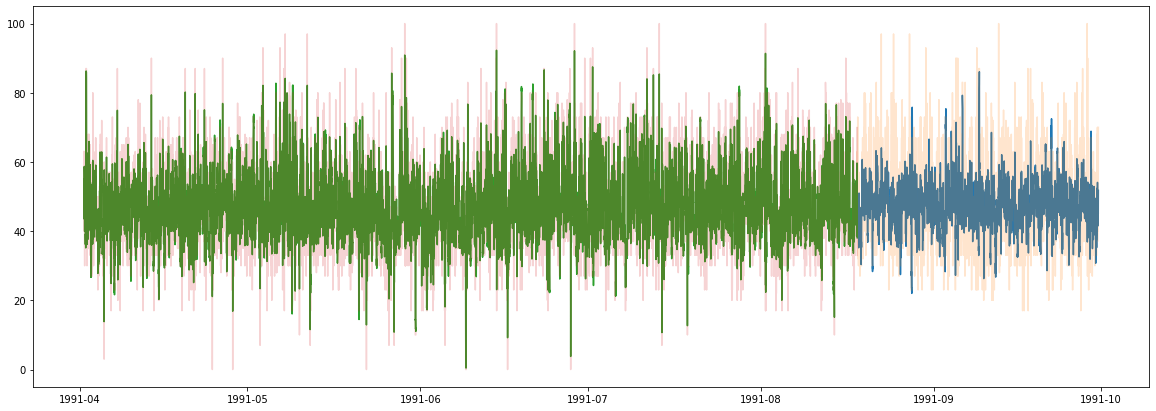

In [481]:
plt.figure(figsize=(20,7))
plt.plot(pre_te)
plt.plot(EB00_test,alpha=0.2)
plt.plot(pre_tr)
plt.plot(EB00_train,alpha=0.2)

In [475]:
# Log Returns
GSPC_test_n=GSPC_test.copy()
GSPC_test_n['log_ret'] = np.log(GSPC_test.iloc[:,0]).diff()
#pure_mm_lstm['log_ret'] = np.log(pure_mm_lstm.iloc[:,0]).diff()
pure_mm_cnng['log_ret'] = np.log(pure_mm_cnng.iloc[:,0]).diff()


plt.figure(figsize=(20,4),dpi=200)
plt.subplot(1,2,1)
plt.plot(GSPC_test_n['log_ret'], 'r-', linewidth=2, label='Original log return')
plt.ylim(-0.2,0.2)
plt.title('log return of original data')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(pure_mm_cnng['log_ret'] , 'b-', linewidth=2, label='Denoised log return')
plt.ylim(-0.2,0.2)
plt.title('log return of denoised data(CNN)')
plt.legend(loc='best')

# plt.subplot(1,3,3)
# plt.plot(pure_mm_lstm['log_ret'], 'y-', linewidth=2, label='Denoised log return')
# plt.ylim(-0.2,0.2)
# plt.title('log return of denoised data(LSTM)')
# plt.legend(loc='best')

plt.show()

NameError: name 'GSPC_test' is not defined

In [ ]:
import warnings
warnings.filterwarnings("ignore")
#warnings.filterwarnings("default")

In [85]:
def svmf1(dataset,dataset2,long_predict=10):
    f1=np.empty(0)
    f12=np.empty(0)
    max_t=0
    if dataset['log_ret'].max()>dataset2['log_ret'].max():
        max_t=dataset['log_ret'].max()
    else:
        max_t=dataset2['log_ret'].max()
    for n in np.arange(0.0, (0.5*max_t), (0.5*max_t)/50):#get multiple threshold
        threshold = n
        # for dataset
        daily_label=np.empty(0)#make the data labelled
        for i in range(0,len(dataset)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label=np.append(daily_label,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label=np.append(daily_label,n)
            else:
                n=1
                daily_label=np.append(daily_label,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        f1=np.append(f1,cross_val_score(svc_rbf , X_train, Y_train, scoring='f1_micro',cv=2,error_score=1).mean())
        
        # for dataset2
        daily_label2=np.empty(0)#make the data labelled
        for i in range(0,len(dataset2)):
            if dataset2.iloc[i,1]<-threshold:
                n=-1
                daily_label2=np.append(daily_label2,n)
            elif abs(dataset2.iloc[i,1])<=threshold:
                n=0
                daily_label2=np.append(daily_label2,n)
            else:
                n=1
                daily_label2=np.append(daily_label2,n)
        X2=pd.DataFrame()
        Y2=pd.DataFrame()
        for i in range(1,len(dataset2)-long_predict):
            X2=pd.concat([X2, pd.DataFrame(dataset2.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y2=pd.concat([Y2, pd.DataFrame(daily_label2[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X2=np.array(X2)
        Y2=np.array(Y2[0])
        X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, Y2, test_size=0.2,random_state=1)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        f12=np.append(f12,cross_val_score(svc_rbf , X_train2, Y_train2, scoring='f1_micro',cv=2,error_score=1).mean())
    return f1,f12

In [86]:
original_svmg,denoised_svmg=svmf1(GSPC_test_n,pure_mm_cnng)

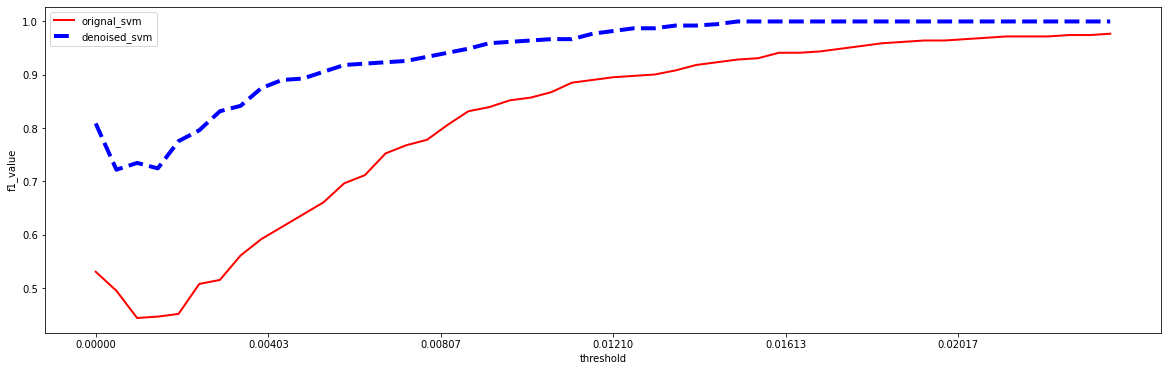

In [89]:
plt.figure(figsize=(20,6))
max_t=0
if GSPC_test_n['log_ret'].max()>pure_mm_cnng['log_ret'].max():
    max_t=GSPC_test_n['log_ret'].max()
else:
    max_t=pure_mm_cnng['log_ret'].max()
plt.plot(np.arange(0.0,(0.5*max_t), (0.5*max_t)/50),original_svmg,label='orignal_svm', color='red', linewidth=2.0)
plt.plot(np.arange(0.0,(0.5*max_t), (0.5*max_t)/50),denoised_svmg,label='denoised_svm', color='blue', linewidth=4.0, linestyle='--')

plt.xticks(np.arange(0.0,(0.5*max_t), (0.5*max_t)/6))
plt.xlabel('threshold')
plt.ylabel('f1_value')
plt.legend()

In [435]:
orignal_svm=svmf1(GSPC_test)
denoised_svm=svmf1(pure_mm_lstm)

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(np.arange(0.0, 0.007, 0.0005),orignal_svm,label='orignal_svm', color='red', linewidth=2.0)
plt.plot(np.arange(0.0, 0.007, 0.0005),denoised_svm,label='denoised_svm', color='blue', linewidth=4.0, linestyle='--')
plt.xticks(np.arange(0.0, 0.007, 0.001))
plt.xlabel('threshold')
plt.ylabel('f1_value')
plt.legend()

In [90]:
def bbands(close_prices, window, no_of_stdev):#bollinger  bands, using today's closing price

    rolling_mean = close_prices.rolling(window,min_periods=1).mean()#.shift(1)
    rolling_std = close_prices.rolling(window,min_periods=1).std()#.shift(1)
    

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band

In [91]:
def buy_signal_function(dataset):
    buy_signal=pd.DataFrame(columns=['Price'],index=dataset.index)
    buy_signal['Price']=dataset['Close']
    buy_signal['mean'],buy_signal['upper'],buy_signal['lower']=bbands(dataset['Close'],20,2)
    buy_signal['side'] = np.nan 
    buy_signal['signal'] = np.nan 
    for i in range(0,len(dataset)):
        if (buy_signal.iloc[i,0]<buy_signal.iloc[i,3]):
            buy_signal.iloc[i,4]=1
            if (buy_signal.iloc[i-1,0]>=buy_signal.iloc[i-1,3]):
                buy_signal.iloc[i,5]=1
        elif (buy_signal.iloc[i,0]>buy_signal.iloc[i,2]):
            buy_signal.iloc[i,4]=-1
            if (buy_signal.iloc[i-1,0]<=buy_signal.iloc[i-1,2]):
                buy_signal.iloc[i,5]=-1
    return buy_signal

In [92]:
GSPC_test_signal=buy_signal_function(GSPC_test_n)
#GSPC_test_signal
# GSPC_test_signal[~np.isnan(GSPC_test_signal['signal'])]
# GSPC_test_signal[GSPC_test_signal['signal']==1.0]

pure_mm_cnng_signal=buy_signal_function(pure_mm_cnng)
#pure_mm_cnn_signal
#pure_mm_cnn_signal[pure_mm_cnn_signal['signal']==1.0]

#pure_mm_lstm_signal=buy_signal_function(pure_mm_lstm,GSPC_test_n,pure_mm_cnn,pure_mm_lstm)
#pure_mm_lstm_signal
#pure_mm_lstm_signal[pure_mm_lstm_signal['signal']==1.0]

In [93]:
# Compute sides
# print('GSPC_test_side:\n',GSPC_test_signal.side.value_counts(),'\n')
# print('pure_mm_cnn_side:\n',pure_mm_cnn_signal.side.value_counts(),'\n')
# print('pure_mm_lstm_side:\n',pure_mm_lstm_signal.side.value_counts(),'\n')

print('GSPC_test_signal:\n',GSPC_test_signal.signal.value_counts(),'\n')
print('pure_mm_cnng_signal:\n',pure_mm_cnng_signal.signal.value_counts(),'\n')
#print('pure_mm_lstm_signal:\n',pure_mm_lstm_signal.signal.value_counts(),'\n')


GSPC_test_signal:
 -1.0    17
 1.0    14
Name: signal, dtype: int64 

pure_mm_cnng_signal:
 -1.0    9
 1.0    9
Name: signal, dtype: int64 



In [94]:
# GSPC_test_signal.loc[GSPC_test_signal.signal == 1.0].index

print(GSPC_test[GSPC_test_signal.signal == 1.0])
print(GSPC_test[pure_mm_cnng_signal.signal == 1.0])

                  Close
Date                   
2017-03-21  2344.020020
2017-04-13  2328.949951
2017-06-29  2419.699951
2017-07-06  2409.750000
2017-08-10  2438.209961
2017-08-17  2430.010010
2018-02-05  2648.939941
2018-02-08  2581.000000
2018-03-22  2643.689941
2018-06-27  2699.629883
2018-10-10  2785.679932
2018-10-24  2656.100098
2018-12-17  2545.939941
2018-12-19  2506.959961
                  Close
Date                   
2017-03-22  2348.449951
2017-04-18  2342.189941
2017-08-21  2428.370117
2018-02-08  2581.000000
2018-03-26  2658.550049
2018-06-29  2718.370117
2018-10-11  2728.370117
2018-10-26  2658.689941
2018-12-20  2467.419922


In [95]:
# GSPC_test_signal.loc[GSPC_test_signal.signal == 1.0].index

print(GSPC_test[GSPC_test_signal.signal == -1.0])
print(GSPC_test[pure_mm_cnng_signal.signal == -1.0])

                  Close
Date                   
2017-01-24  2280.070068
2017-02-10  2316.100098
2017-02-21  2365.379883
2017-04-25  2388.610107
2017-06-02  2439.070068
2017-07-14  2459.270020
2017-07-19  2473.830078
2017-09-12  2496.479980
2017-10-05  2552.070068
2017-10-27  2581.070068
2017-11-28  2627.040039
2018-01-04  2723.989990
2018-01-12  2786.239990
2018-05-10  2723.070068
2018-06-06  2772.350098
2018-08-27  2896.739990
2018-09-20  2930.750000
                  Close
Date                   
2017-02-07  2293.080078
2017-04-26  2387.449951
2017-05-26  2415.820068
2017-07-17  2459.139893
2017-10-04  2537.739990
2017-11-27  2601.419922
2018-01-08  2747.709961
2018-06-07  2770.370117
2018-08-29  2914.040039


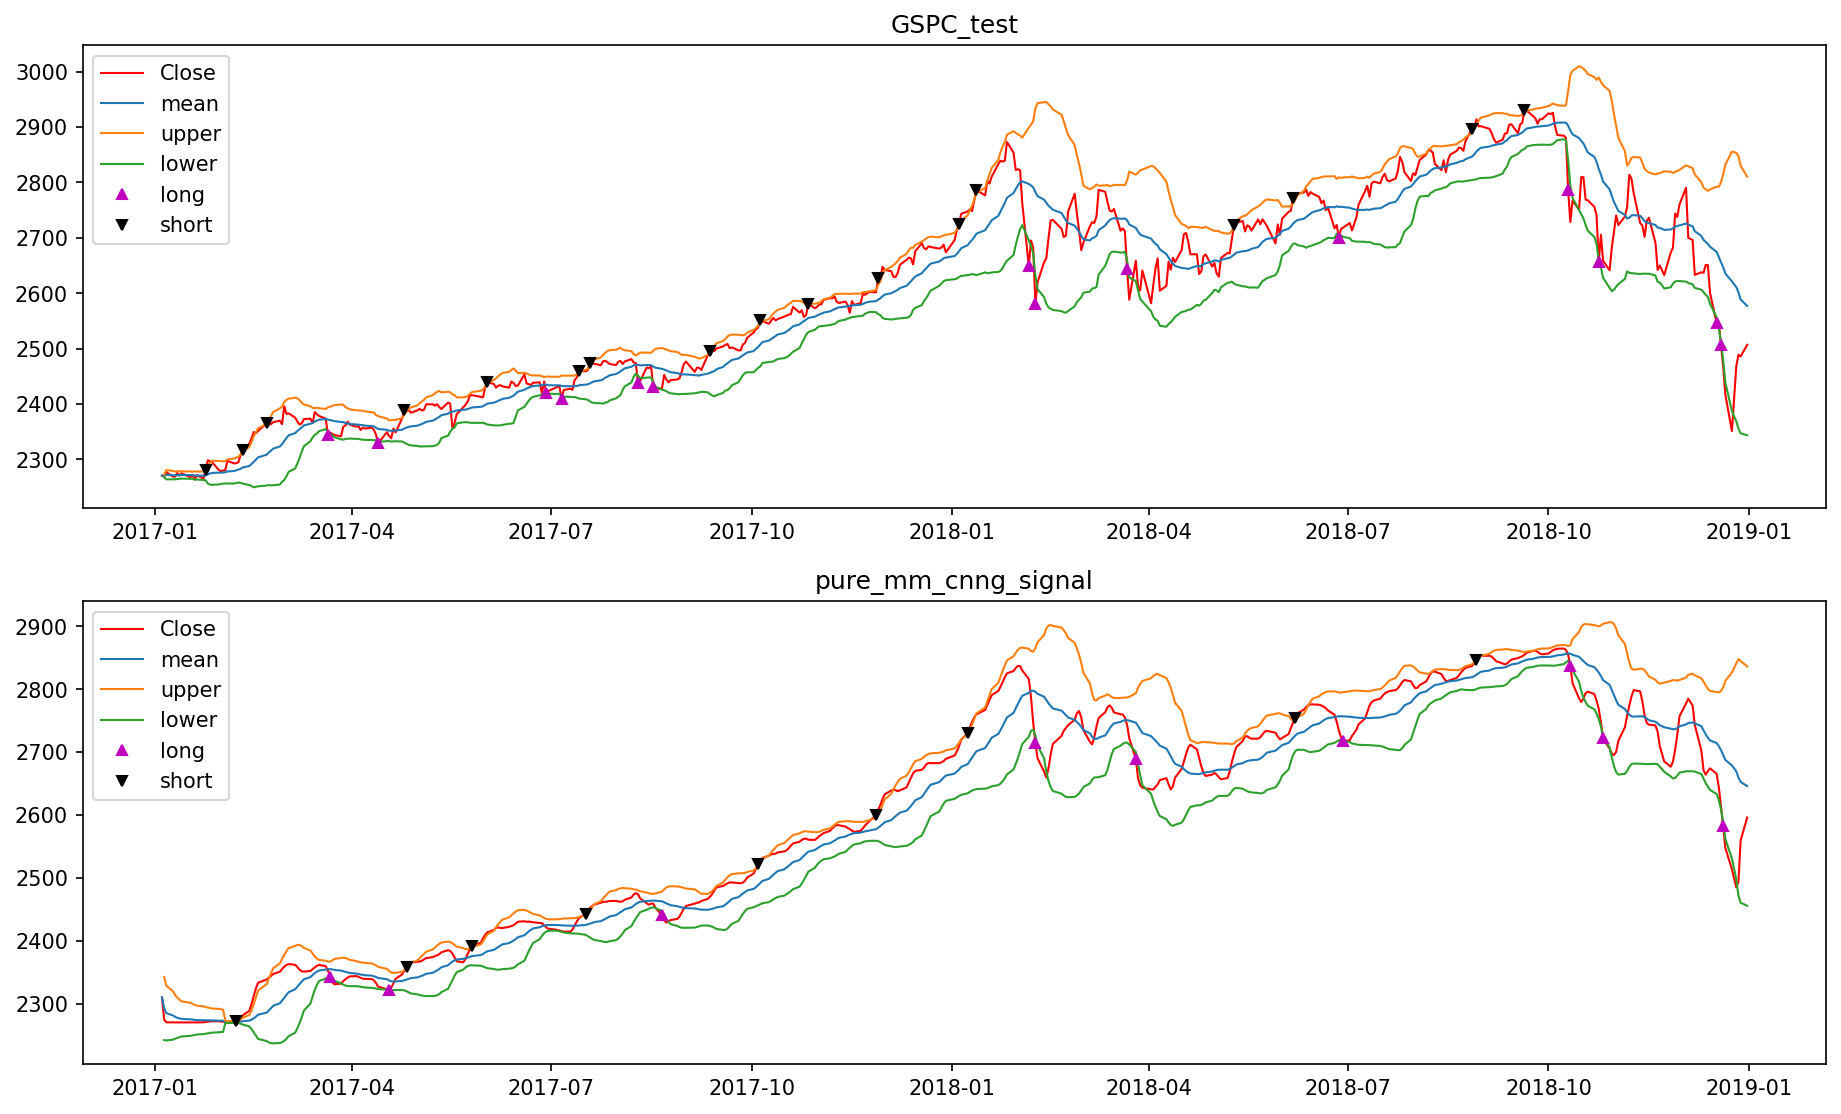

In [96]:
plt.figure(figsize=(15,9),dpi=150)
plt.subplot(2,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test_signal['Price'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_signal[['mean','upper','lower']], lw=1,label=['mean','upper','lower'])
plt.plot(GSPC_test_signal.loc[GSPC_test_signal.signal == 1.0].index, 
         GSPC_test_signal.Price[GSPC_test_signal.signal == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(GSPC_test_signal.loc[GSPC_test_signal.signal == -1.0].index, 
         GSPC_test_signal.Price[GSPC_test_signal.signal == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()         


plt.subplot(2,1,2)
plt.title('pure_mm_cnng_signal')
plt.plot(pure_mm_cnng_signal['Price'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnng_signal[['mean','upper','lower']], lw=1,label=['mean','upper','lower'])
plt.plot(pure_mm_cnng_signal.loc[pure_mm_cnng_signal.signal == 1.0].index, 
         pure_mm_cnng_signal.Price[pure_mm_cnng_signal.signal == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(pure_mm_cnng_signal.loc[pure_mm_cnng_signal.signal == -1.0].index, 
         pure_mm_cnng_signal.Price[pure_mm_cnng_signal.signal == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()    

# plt.subplot(3,1,3)
# plt.title('pure_mm_lstm_signal')
# plt.plot(pure_mm_lstm_signal['GSPC_test'], color='r', lw=1,label='Close')
# plt.plot(pure_mm_lstm_signal[['mean','upper','lower']], lw=1,label=['mean','upper','lower'])
# plt.plot(pure_mm_lstm_signal.loc[pure_mm_lstm_signal.signal == 1.0].index, 
#          pure_mm_lstm_signal.GSPC_test[pure_mm_lstm_signal.signal == 1.0],
#          '^', markersize=5, color='m',label='long')
# plt.plot(pure_mm_lstm_signal.loc[pure_mm_lstm_signal.signal == -1.0].index, 
#          pure_mm_lstm_signal.GSPC_test[pure_mm_lstm_signal.signal == -1.0],
#          'v', markersize=5, color='k',label='short')
# plt.legend()   

In [97]:
def MACD(dataset,short_window = 12,long_window = 26, signal_window=9):
    # Initiate short and long windows

    # Initialise the `signals` dataframe and add the `signal` column
    signals = pd.DataFrame(index=dataset.index)
    signals['signal'] = 0.0

    # Calculate short term moving averages
    signals['short_mavg'] = dataset['Close'].ewm(span=short_window, min_periods=1).mean()

    # Calculate long term moving averages
    signals['long_mavg'] = dataset['Close'].ewm(span=long_window, min_periods=1).mean()
    
    # Calculate DIF 
    signals['DIF'] = signals['short_mavg']-signals['long_mavg']
    
     # Calculate DIF moving averages
    signals['DEA'] = signals['DIF'].ewm(span=signal_window, min_periods=1).mean()

    # Generate signal
    signals['signal'] = np.where(signals['DIF']> signals['DEA'], 1.0, 0.0)   

    # Generate trading orders
    signals['positions'] = signals['signal'].diff()
    return signals

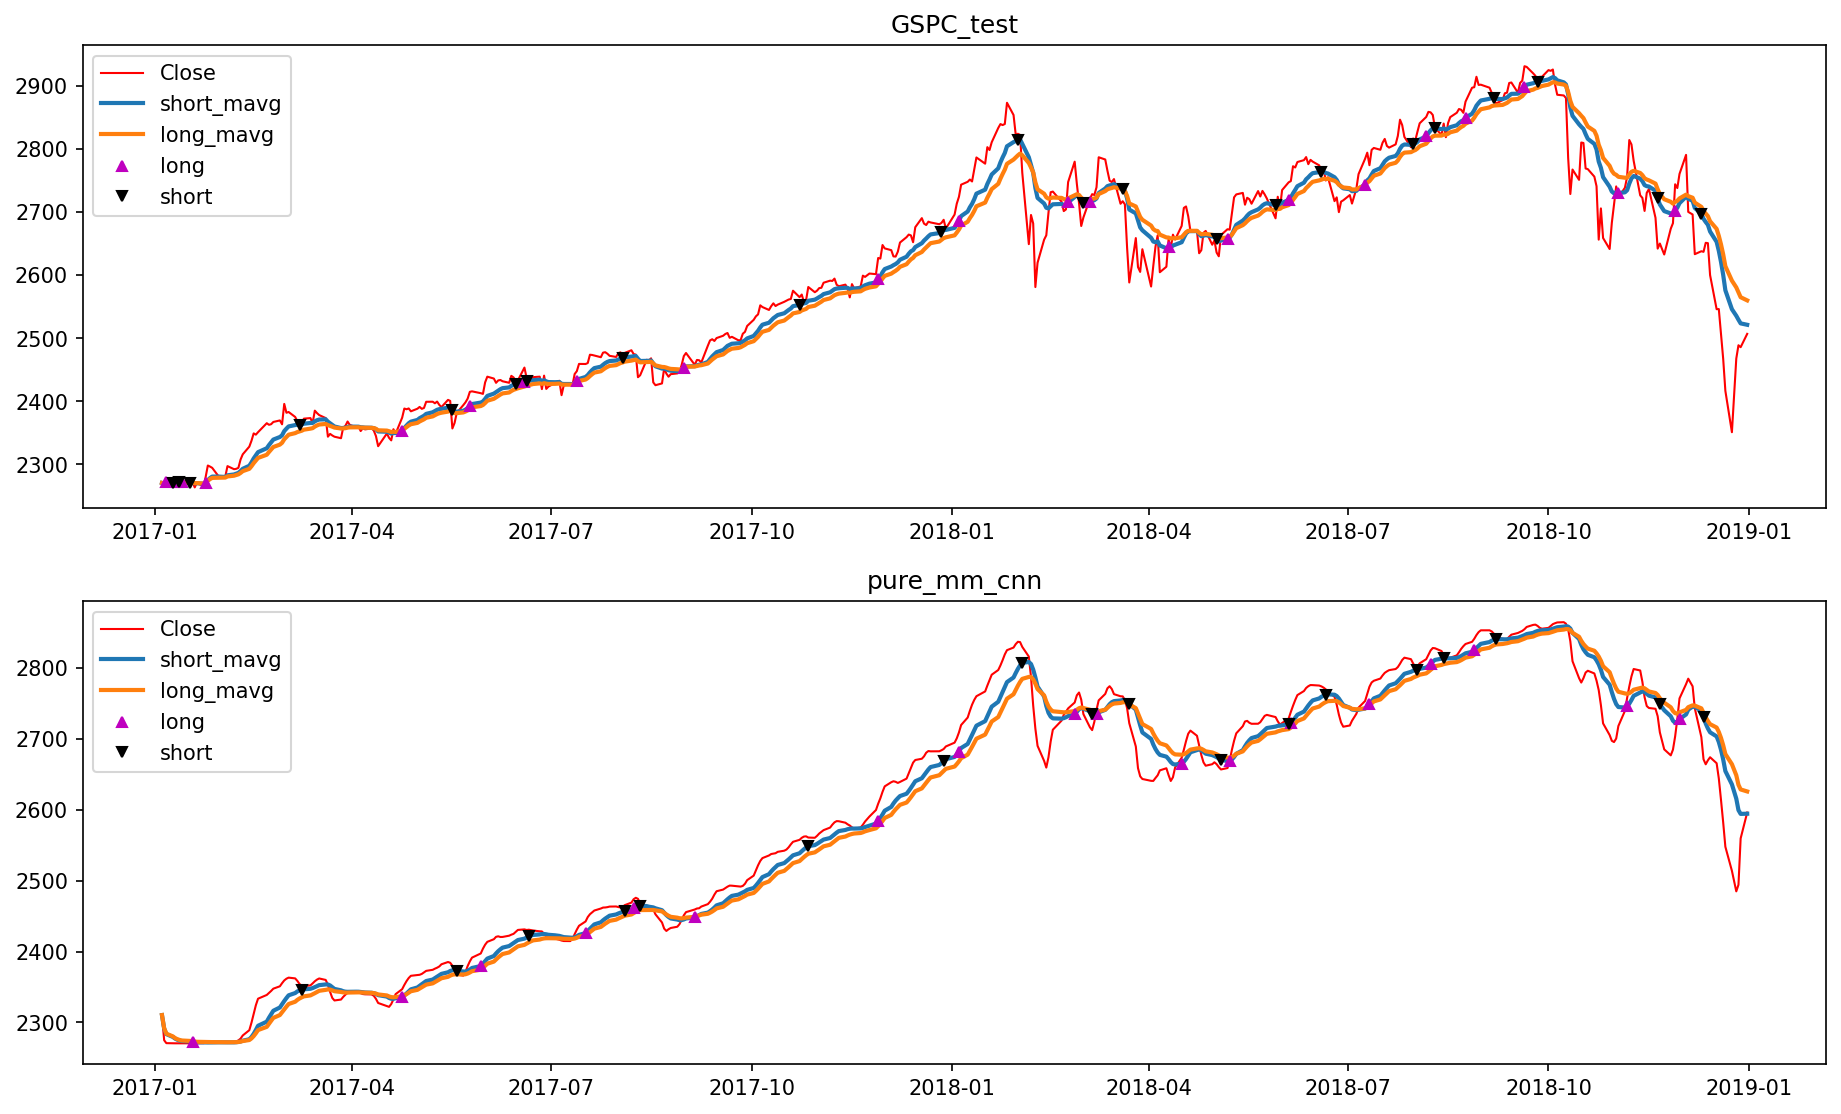

In [98]:
GSPC_test_macd=MACD(GSPC_test_n,short_window = 14,long_window = 22)
pure_mm_cnng_macd=MACD(pure_mm_cnng,short_window = 14,long_window = 22)
#pure_mm_lstm_macd=MACD(pure_mm_lstm,short_window = 14,long_window = 22)

plt.figure(figsize=(15,9),dpi=150)
plt.subplot(2,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test_n['Close'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_macd[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(GSPC_test_macd.loc[GSPC_test_macd.positions == 1.0].index, 
         GSPC_test_macd.short_mavg[GSPC_test_macd.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(GSPC_test_macd.loc[GSPC_test_macd.positions == -1.0].index, 
         GSPC_test_macd.short_mavg[GSPC_test_macd.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()         


plt.subplot(2,1,2)
plt.title('pure_mm_cnn')
plt.plot(pure_mm_cnng['Close'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnng_macd[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(pure_mm_cnng_macd.loc[pure_mm_cnng_macd.positions == 1.0].index, 
         pure_mm_cnng_macd.short_mavg[pure_mm_cnng_macd.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(pure_mm_cnng_macd.loc[pure_mm_cnng_macd.positions == -1.0].index, 
         pure_mm_cnng_macd.short_mavg[pure_mm_cnng_macd.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()   

# plt.subplot(3,1,3)
# plt.title('pure_mm_lstm')
# plt.plot(pure_mm_lstm['Close'], color='r', lw=1,label='Close')
# plt.plot(pure_mm_lstm_macd[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
# plt.plot(pure_mm_lstm_macd.loc[pure_mm_lstm_macd.positions == 1.0].index, 
#          pure_mm_lstm_macd.short_mavg[pure_mm_lstm_macd.positions == 1.0],
#          '^', markersize=5, color='m',label='long')
# plt.plot(pure_mm_lstm_macd.loc[pure_mm_lstm_macd.positions == -1.0].index, 
#          pure_mm_lstm_macd.short_mavg[pure_mm_lstm_macd.positions == -1.0],
#          'v', markersize=5, color='k',label='short')
# plt.legend()   

In [99]:
print('GSPC_test_macd:\n',GSPC_test_macd.positions.value_counts(),'\n')
print('pure_mm_cnng_macd:\n',pure_mm_cnng_macd.positions.value_counts(),'\n')

GSPC_test_macd:
  0.0    456
 1.0     22
-1.0     22
Name: positions, dtype: int64 

pure_mm_cnng_macd:
  0.0    464
 1.0     18
-1.0     18
Name: positions, dtype: int64 



In [100]:
print(GSPC_test[GSPC_test_macd['positions']==1])
print(GSPC_test[pure_mm_cnng_macd['positions']==1])

                  Close
Date                   
2017-01-06  2276.979980
2017-01-11  2275.320068
2017-01-13  2274.639893
2017-01-24  2280.070068
2017-04-24  2374.149902
2017-05-25  2415.070068
2017-06-19  2453.459961
2017-07-13  2447.830078
2017-08-31  2471.649902
2017-11-28  2627.040039
2018-01-04  2723.989990
2018-02-23  2747.300049
2018-03-05  2720.939941
2018-04-10  2656.870117
2018-05-07  2672.629883
2018-06-04  2746.870117
2018-07-09  2784.169922
2018-08-06  2850.399902
2018-08-24  2874.689941
2018-09-20  2930.750000
2018-11-02  2723.060059
2018-11-28  2743.790039
                  Close
Date                   
2017-01-18  2271.889893
2017-04-24  2374.149902
2017-05-30  2412.909912
2017-07-17  2459.139893
2017-08-08  2474.919922
2017-09-05  2457.850098
2017-11-28  2627.040039
2018-01-04  2723.989990
2018-02-26  2779.600098
2018-03-08  2738.969971
2018-04-16  2677.840088
2018-05-08  2671.919922
2018-06-05  2748.800049
2018-07-11  2774.020020
2018-08-08  2857.699951
2018-08-28  2897

In [101]:
print(GSPC_test[GSPC_test_macd['positions']==-1])
print(GSPC_test[pure_mm_cnng_macd['positions']==-1])

                  Close
Date                   
2017-01-09  2268.899902
2017-01-12  2270.439941
2017-01-17  2267.889893
2017-03-08  2362.979980
2017-05-17  2357.030029
2017-06-15  2432.459961
2017-06-20  2437.030029
2017-08-03  2472.159912
2017-10-23  2564.979980
2017-12-27  2682.620117
2018-01-31  2823.810059
2018-03-02  2691.250000
2018-03-20  2716.939941
2018-05-02  2635.669922
2018-05-29  2689.860107
2018-06-19  2762.590088
2018-07-31  2816.290039
2018-08-10  2833.280029
2018-09-06  2878.050049
2018-09-26  2905.969971
2018-11-20  2641.889893
2018-12-10  2637.719971
                  Close
Date                   
2017-03-09  2364.870117
2017-05-19  2381.729980
2017-06-21  2435.610107
2017-08-04  2476.830078
2017-08-11  2441.320068
2017-10-27  2581.070068
2017-12-28  2687.540039
2018-02-02  2762.129883
2018-03-06  2728.120117
2018-03-23  2588.260010
2018-05-04  2663.419922
2018-06-04  2746.870117
2018-06-21  2749.760010
2018-08-02  2827.219971
2018-08-14  2839.959961
2018-09-07  2871

In [102]:
def MA(dataset,short_window = 10,long_window = 50):
    # Initiate short and long windows

    # Initialise the `signals` dataframe and add the `signal` column
    signals = pd.DataFrame(index=dataset.index)
    signals['signal'] = 0.0

    # Calculate short term simple moving averages
    signals['short_mavg'] = dataset['Close'].rolling(window=short_window, min_periods=1).mean()

    # Calculate long term simple moving averages
    signals['long_mavg'] = dataset['Close'].rolling(window=long_window, min_periods=1).mean()

    # Generate signal
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                                > signals['long_mavg'][short_window:], 1.0, 0.0)   

    # Generate trading orders
    signals['positions'] = signals['signal'].diff()
    return signals

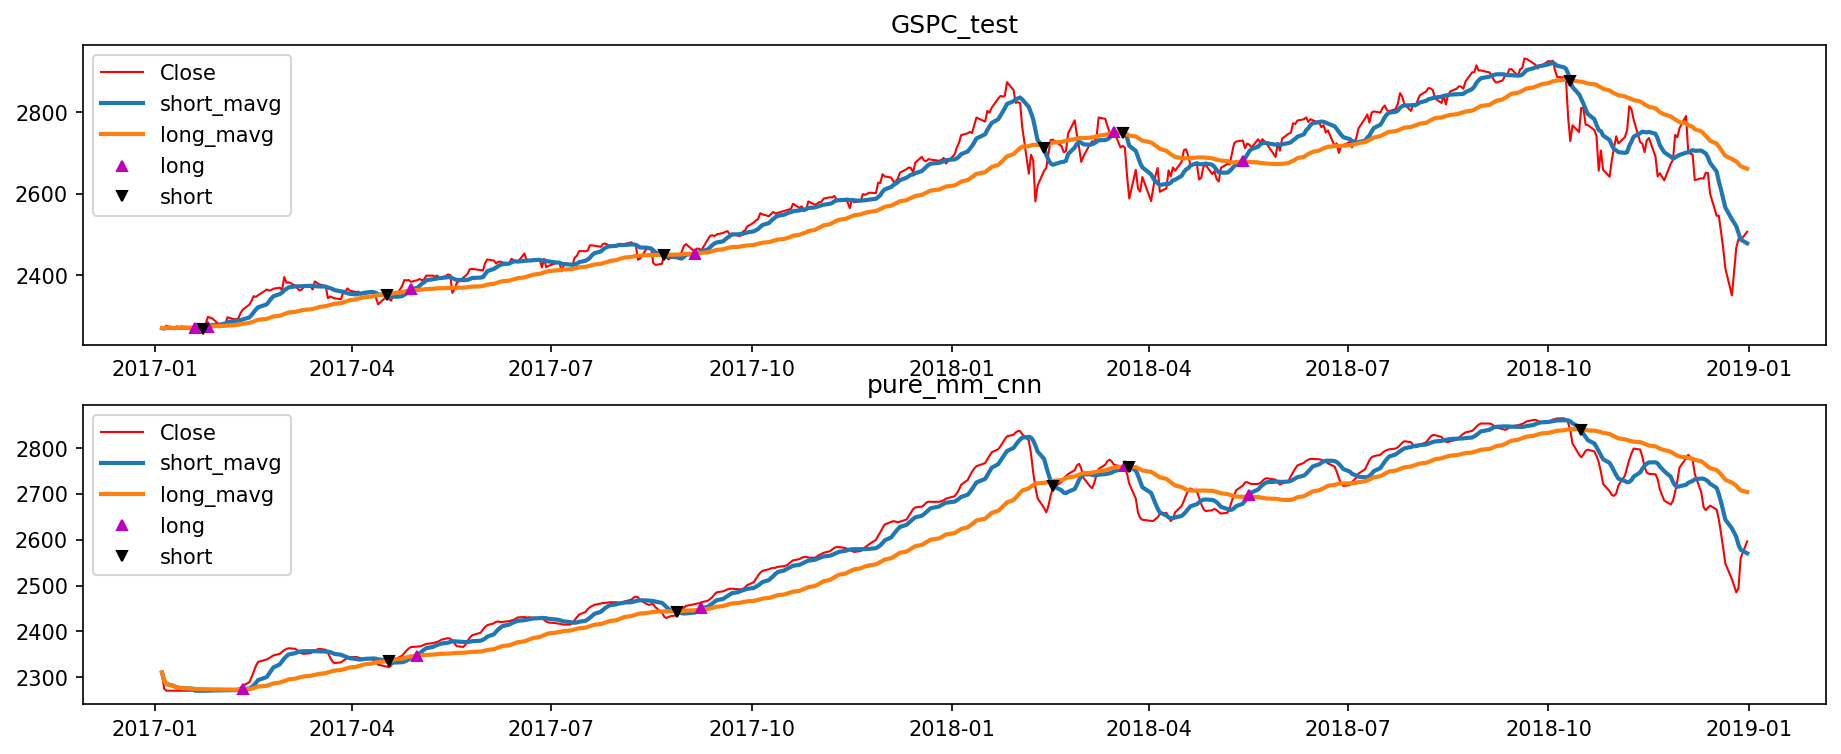

In [103]:
GSPC_test_ma=MA(GSPC_test,short_window = 10,long_window = 50)
pure_mm_cnng_ma=MA(pure_mm_cnng,short_window = 10,long_window = 50)
#pure_mm_lstm_ma=MA(pure_mm_lstm,short_window = 10,long_window = 50)

plt.figure(figsize=(15,9),dpi=150)
plt.subplot(3,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test['Close'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_ma[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(GSPC_test_ma.loc[GSPC_test_ma.positions == 1.0].index, 
         GSPC_test_ma.short_mavg[GSPC_test_ma.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(GSPC_test_ma.loc[GSPC_test_ma.positions == -1.0].index, 
         GSPC_test_ma.short_mavg[GSPC_test_ma.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()         


plt.subplot(3,1,2)
plt.title('pure_mm_cnn')
plt.plot(pure_mm_cnng['Close'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnng_ma[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(pure_mm_cnng_ma.loc[pure_mm_cnng_ma.positions == 1.0].index, 
         pure_mm_cnng_ma.short_mavg[pure_mm_cnng_ma.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(pure_mm_cnng_ma.loc[pure_mm_cnng_ma.positions == -1.0].index, 
         pure_mm_cnng_ma.short_mavg[pure_mm_cnng_ma.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()   

# plt.subplot(3,1,3)
# plt.title('pure_mm_lstm')
# plt.plot(pure_mm_lstm['Close'], color='r', lw=1,label='Close')
# plt.plot(pure_mm_lstm_ma[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
# plt.plot(pure_mm_lstm_ma.loc[pure_mm_lstm_ma.positions == 1.0].index, 
#          pure_mm_lstm_ma.short_mavg[pure_mm_lstm_ma.positions == 1.0],
#          '^', markersize=5, color='m',label='long')
# plt.plot(pure_mm_lstm_ma.loc[pure_mm_lstm_ma.positions == -1.0].index, 
#          pure_mm_lstm_ma.short_mavg[pure_mm_lstm_ma.positions == -1.0],
#          'v', markersize=5, color='k',label='short')
# plt.legend()   

In [104]:
print('GSPC_test_ma:\n',GSPC_test_ma.positions.value_counts(),'\n')
print('pure_mm_cnng_ma:\n',pure_mm_cnng_ma.positions.value_counts(),'\n')

GSPC_test_ma:
  0.0    488
 1.0      6
-1.0      6
Name: positions, dtype: int64 

pure_mm_cnng_ma:
  0.0    490
 1.0      5
-1.0      5
Name: positions, dtype: int64 



In [105]:
print(GSPC_test[GSPC_test_ma['positions']==1])
print(GSPC_test[pure_mm_cnng_ma['positions']==1])

                  Close
Date                   
2017-01-19  2263.689941
2017-01-25  2298.370117
2017-04-28  2384.199951
2017-09-05  2457.850098
2018-03-16  2752.010010
2018-05-14  2730.129883
                  Close
Date                   
2017-02-10  2316.100098
2017-05-01  2388.330078
2017-09-08  2461.429932
2018-03-21  2711.929932
2018-05-17  2720.129883


In [106]:
print(GSPC_test[GSPC_test_ma['positions']==-1])
print(GSPC_test[pure_mm_cnng_ma['positions']==-1])

                  Close
Date                   
2017-01-23  2265.199951
2017-04-17  2349.010010
2017-08-22  2452.510010
2018-02-12  2656.000000
2018-03-20  2716.939941
2018-10-11  2728.370117
                  Close
Date                   
2017-04-18  2342.189941
2017-08-28  2444.239990
2018-02-16  2732.219971
2018-03-23  2588.260010
2018-10-16  2809.919922


In [107]:
def combinesig(dataset,dataset1,dataset2,dataset3):    
    dataset_backtesting=pd.DataFrame()
    dataset_backtesting['Close']=dataset['Close']
    dataset_backtesting['masig']=dataset1['positions']
    dataset_backtesting['macdsig']=dataset2['positions']
    dataset_backtesting['bbsig']=dataset3['signal']
    return dataset_backtesting

In [108]:
GSPC_backtesting=combinesig(GSPC_test,GSPC_test_ma,GSPC_test_macd,GSPC_test_signal)
pure_mm_cnng_backtesting=combinesig(GSPC_test,pure_mm_cnng_ma,pure_mm_cnng_macd,pure_mm_cnng_signal)
#pure_mm_lstm_backtesting=combinesig(GSPC_test,pure_mm_lstm_ma,pure_mm_lstm_macd,pure_mm_lstm_signal)

In [109]:
def backtest(dataset,asset=1e8, signal=''):
    share_number = 0
    cash = asset
    for i in range(len(dataset)):
        if dataset[signal][i]==1:
            share_number=share_number+cash//(100*dataset['Close'][i])*100
            if cash//(100*dataset['Close'][i])*100>0:
                cash=cash-cash//(100*dataset['Close'][i])*100*dataset['Close'][i]
        elif dataset[signal][i]==-1:
            cash=cash+share_number*dataset['Close'][i]
            share_number=0
    asset_now=cash+share_number*dataset['Close'][i]
    return_value=(asset_now-asset)/asset
    return return_value

In [110]:
mareturn=backtest(GSPC_backtesting,signal='masig')
mareturn_cnng=backtest(pure_mm_cnng_backtesting,signal='masig')
#mareturn_lstm=backtest(pure_mm_lstm_backtesting,signal='masig')
print(mareturn)
print(mareturn_cnng)
#print(mareturn_lstm)

0.12136884912109375
0.13249944067382813


In [111]:
mareturn=backtest(GSPC_backtesting,signal='macdsig')
mareturn_cnng=backtest(pure_mm_cnng_backtesting,signal='macdsig')
#mareturn_lstm=backtest(pure_mm_lstm_backtesting,signal='macdsig')
print(mareturn)
print(mareturn_cnng)
#print(mareturn_lstm)

0.03508548461914063
-0.001764463134765625


In [112]:
mareturn=backtest(GSPC_backtesting,signal='bbsig')
mareturn_cnng=backtest(pure_mm_cnng_backtesting,signal='bbsig')
#mareturn_lstm=backtest(pure_mm_lstm_backtesting,signal='bbsig')
print(mareturn)
print(mareturn_cnng)
#print(mareturn_lstm)

0.05261858813476562
0.12312840380859374


## Fit models(ltsm/cnn)

## MinMaxScaler(bit)

In [119]:
mm_t_b = MinMaxScaler()
bnoise_mm = mm_t_b.fit_transform(bit_noisy.T).T
bprue_mm=mm_t_b.transform(bit_pure.T).T
print(bprue_mm.shape)
print(bnoise_mm.shape)

(100, 188227)
(100, 188227)


In [120]:
btrain_prue_mm=np.reshape(bprue_mm,(len(bprue_mm), len(bprue_mm[0]), 1))
btrain_mm=np.reshape(bnoise_mm, (len(bnoise_mm), len(bnoise_mm[0]), 1))

# convert list to numpy array
X_train_mmb = np.asarray(btrain_mm)
Y_train_mmb = np.asarray(btrain_prue_mm)
X_train_mmb, X_val_mmb, Y_train_mmb, Y_val_mmb = train_test_split(X_train_mmb, Y_train_mmb, test_size=0.2,random_state=0)

In [121]:
bit_test = pd.read_csv('bit_c_1m.csv')
bit_test['Open Time']=pd.to_datetime(bit_test['Open Time'])
bit_test.set_index('Open Time', inplace=True)
bit_test=bit_test[1:]
bit_test=pd.DataFrame(bit_test['Close'])
bit_test

,Close
Open Time,
2021-01-01 00:01:00,29009.91
2021-01-01 00:02:00,28989.30
2021-01-01 00:03:00,28982.69
2021-01-01 00:04:00,28975.65
2021-01-01 00:05:00,28937.11
...,...
2021-05-12 05:35:00,57485.07
2021-05-12 05:36:00,57481.49
2021-05-12 05:37:00,57470.00


## LSTM

In [13]:
def set_model_LSTM():
    model = Sequential()
    #model.add(Conv1D(64, kernel_size=2, activation='tanh', padding='same',input_shape=(None, 1)))
    model.add(LSTM(8, input_shape=(None, 1),activation='tanh', return_sequences = True))
    model.add(LSTM(4, activation='tanh',return_sequences = True))
    #model.add(AveragePooling1D(2, padding='same'))
    model.add(LSTM(4, activation='tanh',return_sequences = True))
    model.add(LSTM(8, activation='tanh',return_sequences = True))
    #model.add(UpSampling1D(2))
    #model.add(Dense(1,activation='tanh'))#
    model.add(Conv1D(1,kernel_size=2,activation='relu', padding='same'))
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mae'])
    return model
modelen_LSTM = set_model_LSTM()
modelen_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 8)           320       
                                                                 
 lstm_1 (LSTM)               (None, None, 4)           208       
                                                                 
 lstm_2 (LSTM)               (None, None, 4)           144       
                                                                 
 lstm_3 (LSTM)               (None, None, 8)           416       
                                                                 
 conv1d_5 (Conv1D)           (None, None, 1)           17        
                                                                 
Total params: 1,105
Trainable params: 1,105
Non-trainable params: 0
_________________________________________________________________


In [14]:
callback = EarlyStopping(monitor='loss', patience=10)
history_LSTM = modelen_LSTM.fit(X_train_mm, Y_train_mm, validation_data = (X_val_mm, Y_val_mm), epochs=800, batch_size=32, verbose=1, callbacks=[callback])

Epoch 1/800
3/3 [==============================] - 7s 896ms/step - loss: 0.3136 - mae: 0.4874 - val_loss: 0.3019 - val_mae: 0.4751
Epoch 2/800
3/3 [==============================] - 1s 382ms/step - loss: 0.2920 - mae: 0.4651 - val_loss: 0.2678 - val_mae: 0.4424
Epoch 3/800
3/3 [==============================] - 1s 382ms/step - loss: 0.2563 - mae: 0.4304 - val_loss: 0.2280 - val_mae: 0.4020
Epoch 4/800
3/3 [==============================] - 1s 390ms/step - loss: 0.2154 - mae: 0.3880 - val_loss: 0.1842 - val_mae: 0.3534
Epoch 5/800
3/3 [==============================] - 1s 430ms/step - loss: 0.1713 - mae: 0.3387 - val_loss: 0.1393 - val_mae: 0.3028
Epoch 6/800
3/3 [==============================] - 1s 396ms/step - loss: 0.1272 - mae: 0.2888 - val_loss: 0.0975 - val_mae: 0.2533
Epoch 7/800
3/3 [==============================] - 1s 400ms/step - loss: 0.0875 - mae: 0.2425 - val_loss: 0.0643 - val_mae: 0.2164
Epoch 8/800
3/3 [==============================] - 1s 390ms/step - loss: 0.0581 - m

In [49]:
modelen_LSTM.save_weights('model_weights_LSTM.h5', overwrite=True) 

In [19]:
modelen_LSTM.load_weights('model_weights_LSTM.h5') 

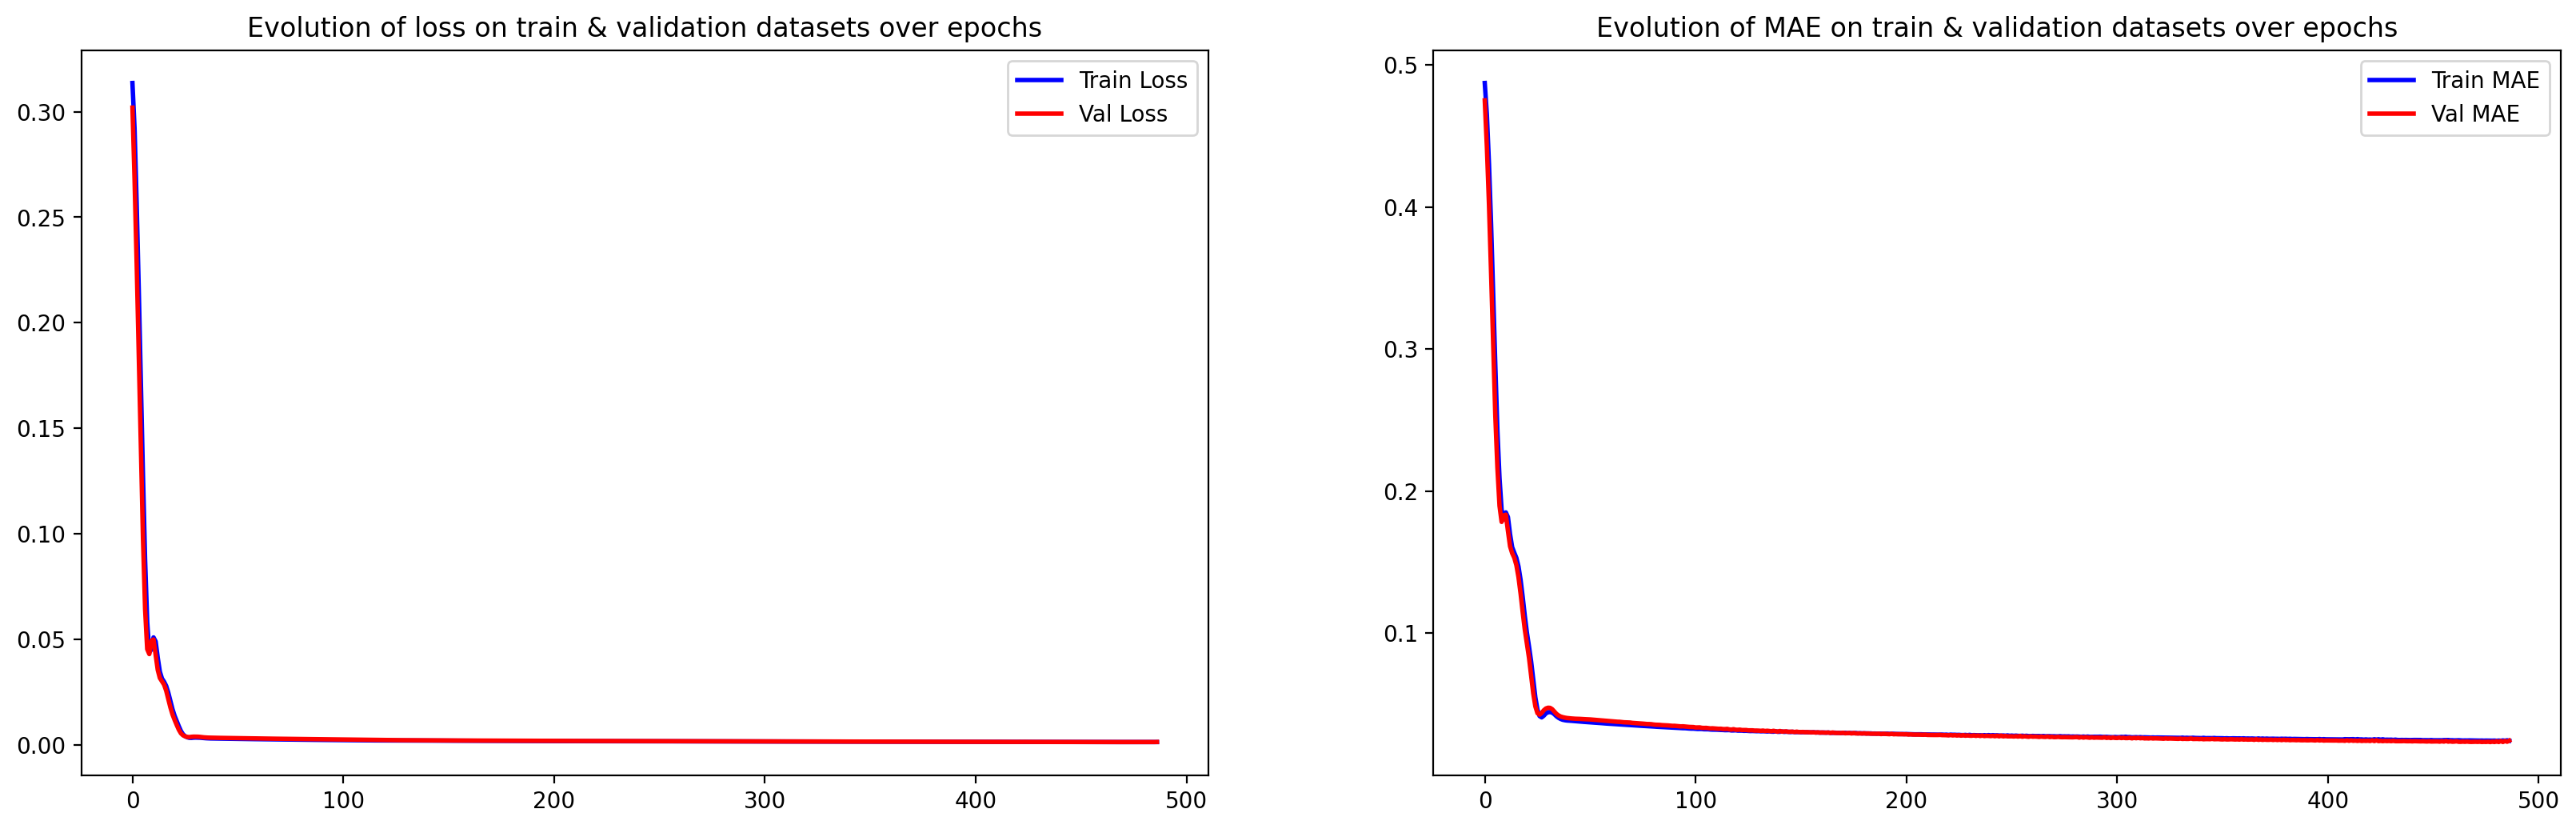

In [15]:
# Check how loss & mae went down
epoch_loss = history_LSTM.history['loss']
epoch_val_loss = history_LSTM.history['val_loss']
epoch_mae = history_LSTM.history['mae']
epoch_val_mae = history_LSTM.history['val_mae']

plt.figure(figsize=(20,6),dpi=200)
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

1/1 [==============================] - 1s 1s/step


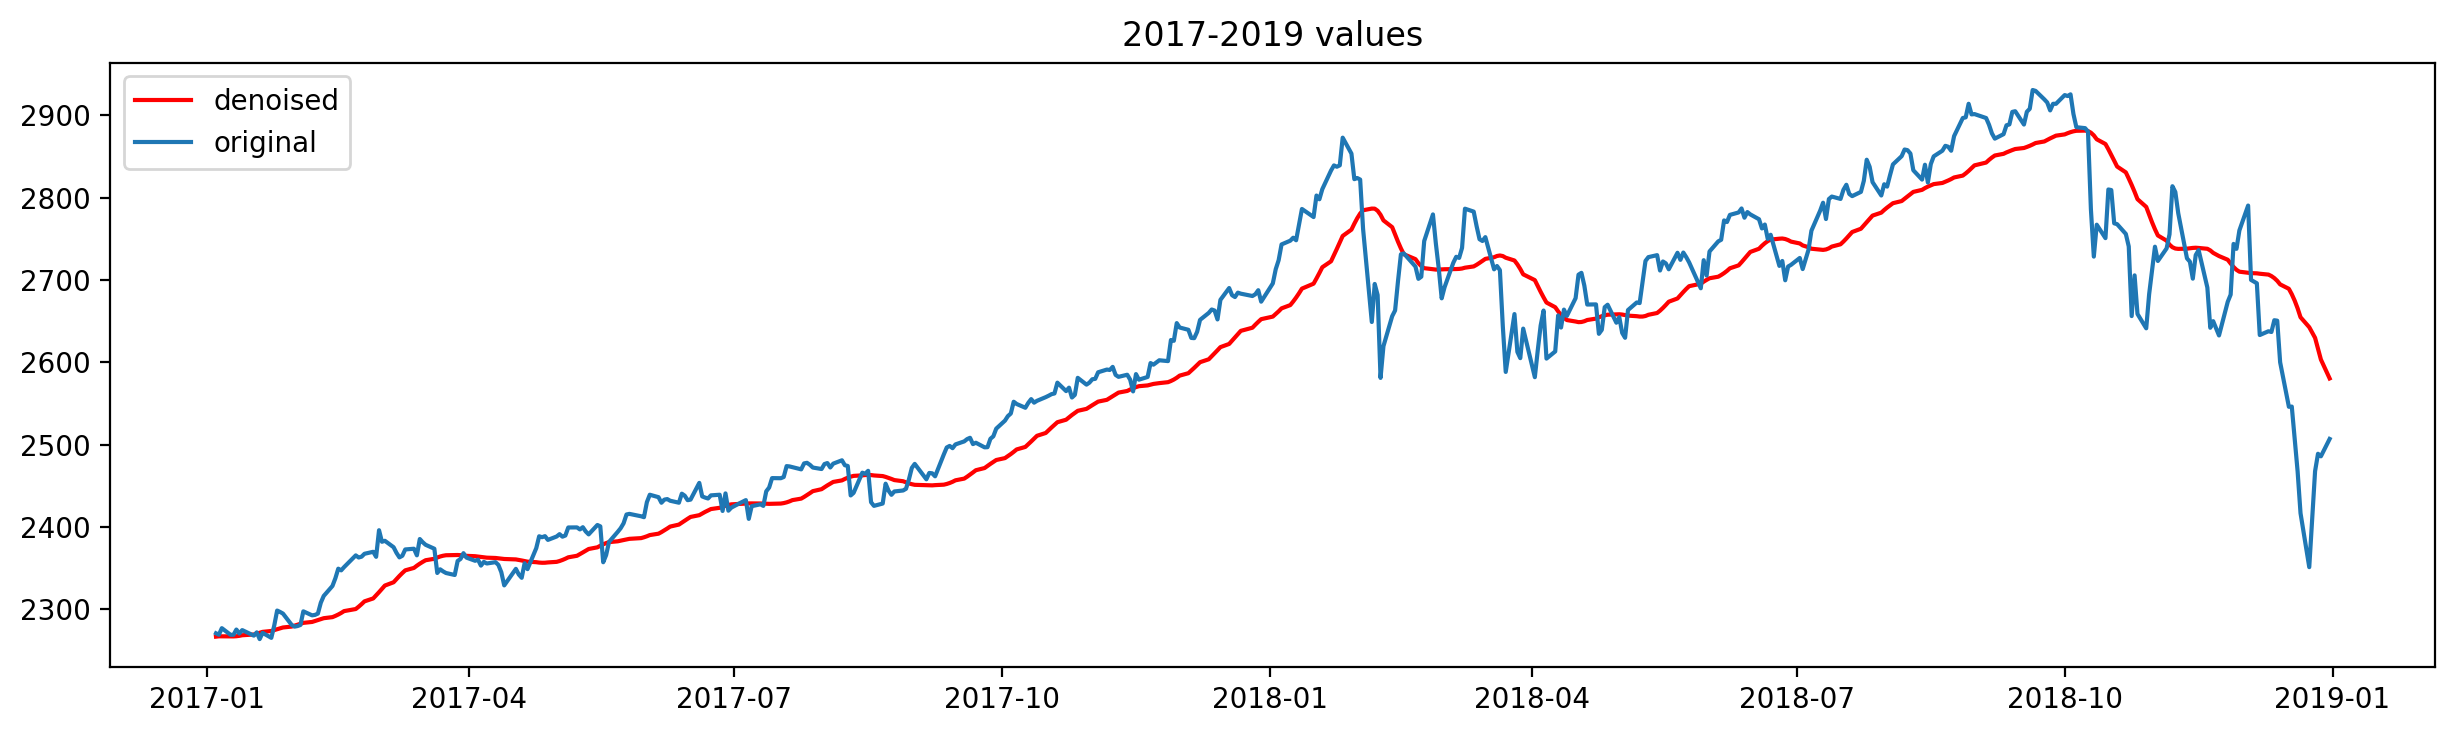

In [16]:
mm_t = MinMaxScaler()
noise_mm_T=mm_t.fit_transform(GSPC_test)
Y_test_mm_lstm = modelen_LSTM.predict(noise_mm_T.T, batch_size=16)
Y_test_mm_lstm=Y_test_mm_lstm.reshape((len(GSPC_test),1))
pure_mm_lstm = mm_t.inverse_transform(Y_test_mm_lstm)
pure_mm_lstm=pd.DataFrame(pure_mm_lstm,columns=['Close'],index=GSPC_test.index)
plt.figure(figsize=(15,4),dpi=200)
plt.plot(pure_mm_lstm,'r')
plt.plot(GSPC_test)
plt.title('2017-2019 values')
plt.legend(['denoised', 'original'], loc='upper left')

## CNN

In [122]:
def set_model_encoding_mmb():
    model = Sequential()
    model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same',input_shape=(None, 1)))
    model.add(Conv1D(64, kernel_size=3,activation='relu',padding='same'))
    model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
    model.add(Conv1D(128, kernel_size=3,activation='relu',padding='same'))
    model.add(Conv1D(1,kernel_size=1,activation='sigmoid', padding='same'))
    model.compile(optimizer='adam' , loss='mse', metrics=['mae'])
    return model
modelen_mmb = set_model_encoding_mmb()
modelen_mmb.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_80 (Conv1D)          (None, None, 128)         512       
                                                                 
 conv1d_81 (Conv1D)          (None, None, 64)          24640     
                                                                 
 conv1d_82 (Conv1D)          (None, None, 64)          12352     
                                                                 
 conv1d_83 (Conv1D)          (None, None, 128)         24704     
                                                                 
 conv1d_84 (Conv1D)          (None, None, 1)           129       
                                                                 
Total params: 62,337
Trainable params: 62,337
Non-trainable params: 0
_________________________________________________________________


In [123]:
callback = EarlyStopping(monitor='loss', patience=10)
history_mmb = modelen_mmb.fit(X_train_mmb, Y_train_mmb, validation_data = (X_val_mmb, Y_val_mmb), epochs=40, batch_size=32, verbose=1, callbacks=[callback])

Epoch 1/40
3/3 [==============================] - 66s 19s/step - loss: 0.0690 - mae: 0.2343 - val_loss: 0.0576 - val_mae: 0.2066
Epoch 2/40
3/3 [==============================] - 58s 17s/step - loss: 0.0544 - mae: 0.1967 - val_loss: 0.0489 - val_mae: 0.1722
Epoch 3/40
3/3 [==============================] - 57s 18s/step - loss: 0.0489 - mae: 0.1678 - val_loss: 0.0480 - val_mae: 0.1613
Epoch 4/40
3/3 [==============================] - 59s 18s/step - loss: 0.0463 - mae: 0.1599 - val_loss: 0.0424 - val_mae: 0.1605
Epoch 5/40
3/3 [==============================] - 58s 18s/step - loss: 0.0419 - mae: 0.1624 - val_loss: 0.0401 - val_mae: 0.1624
Epoch 6/40
3/3 [==============================] - 61s 18s/step - loss: 0.0387 - mae: 0.1578 - val_loss: 0.0350 - val_mae: 0.1430
Epoch 7/40
3/3 [==============================] - 58s 17s/step - loss: 0.0341 - mae: 0.1385 - val_loss: 0.0313 - val_mae: 0.1289
Epoch 8/40
3/3 [==============================] - 60s 17s/step - loss: 0.0300 - mae: 0.1263 - val

In [124]:
modelen_mm.save_weights('model_weights_mmb.h5', overwrite=True)  

NameError: name 'modelen_mm' is not defined

In [ ]:
modelen_mm.load_weights('model_weights_mmb.h5') 

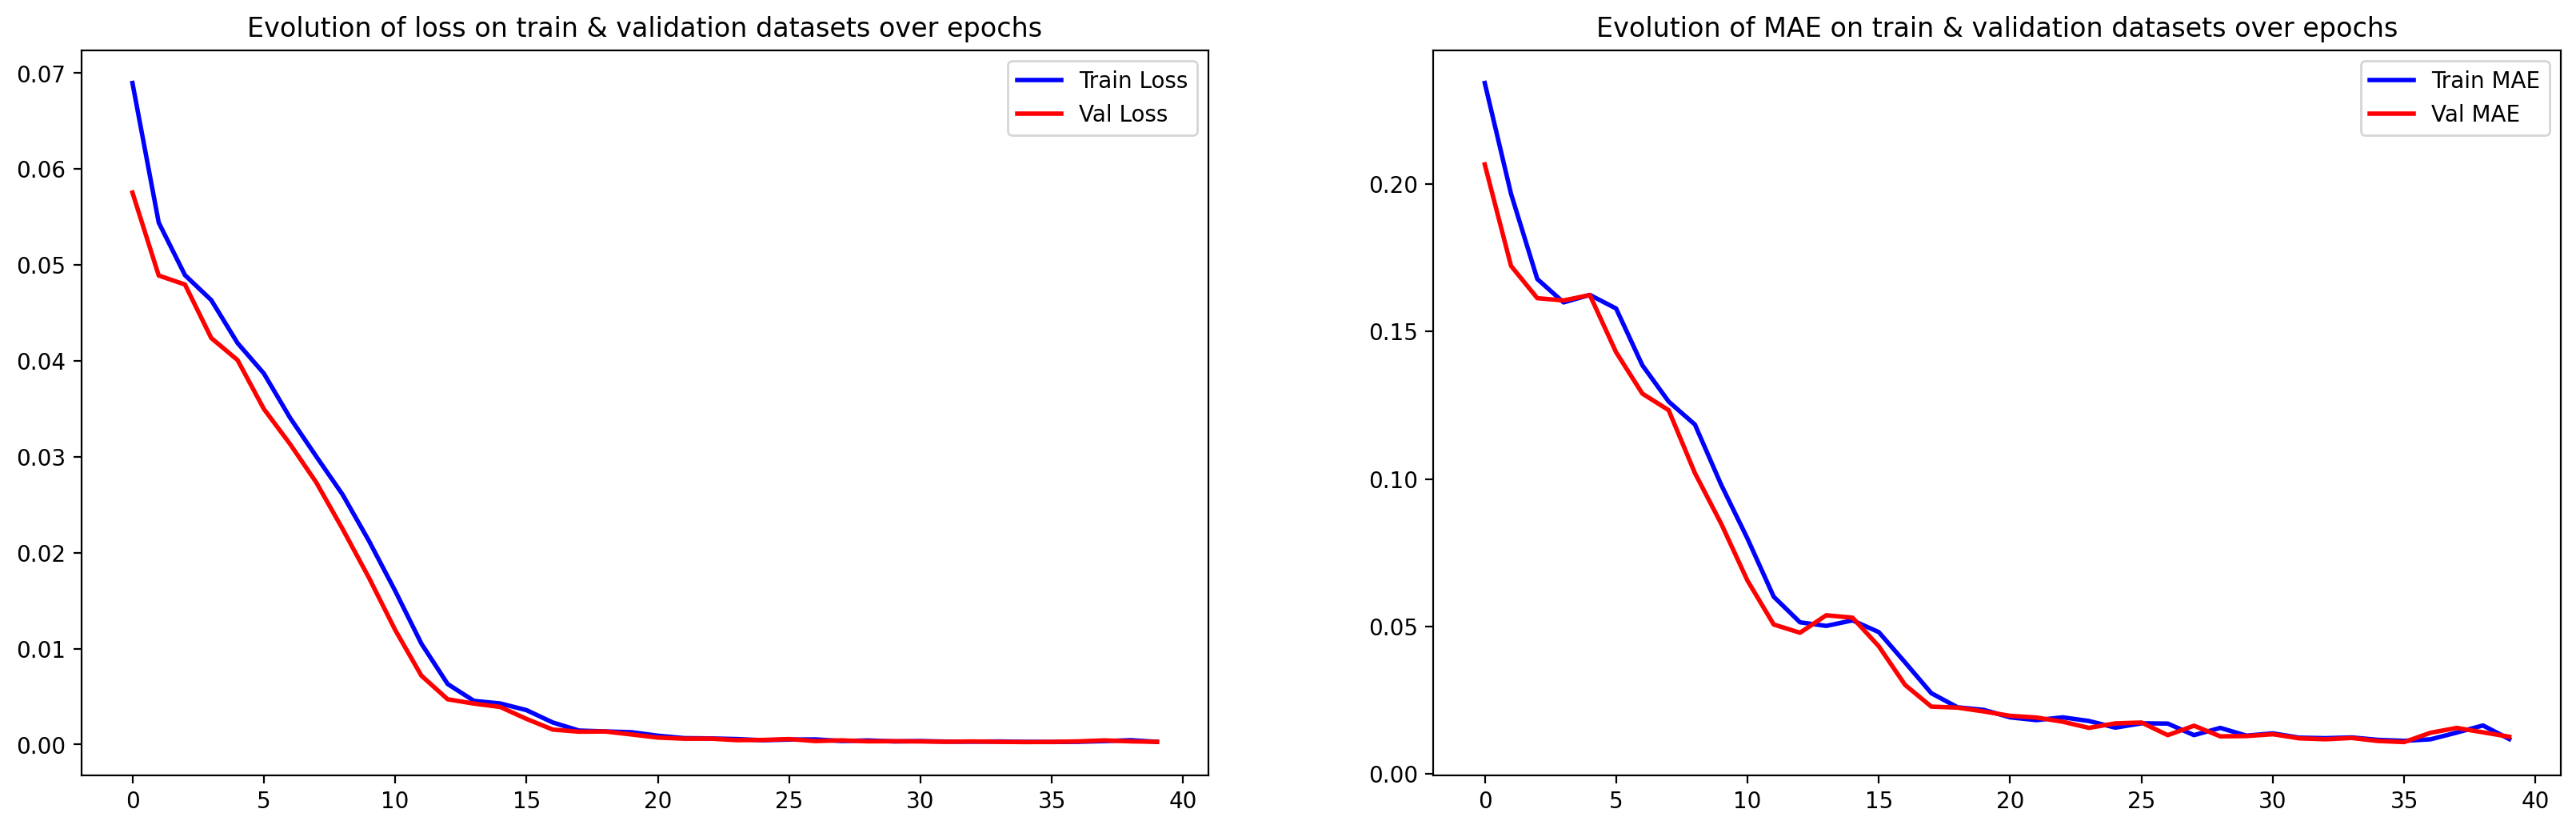

In [125]:
# Check how loss & mae went down
epoch_loss = history_mmb.history['loss']
epoch_val_loss = history_mmb.history['val_loss']
epoch_mae = history_mmb.history['mae']
epoch_val_mae = history_mmb.history['val_mae']

plt.figure(figsize=(20,6),dpi=200)
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

1/1 [==============================] - 0s 279ms/step


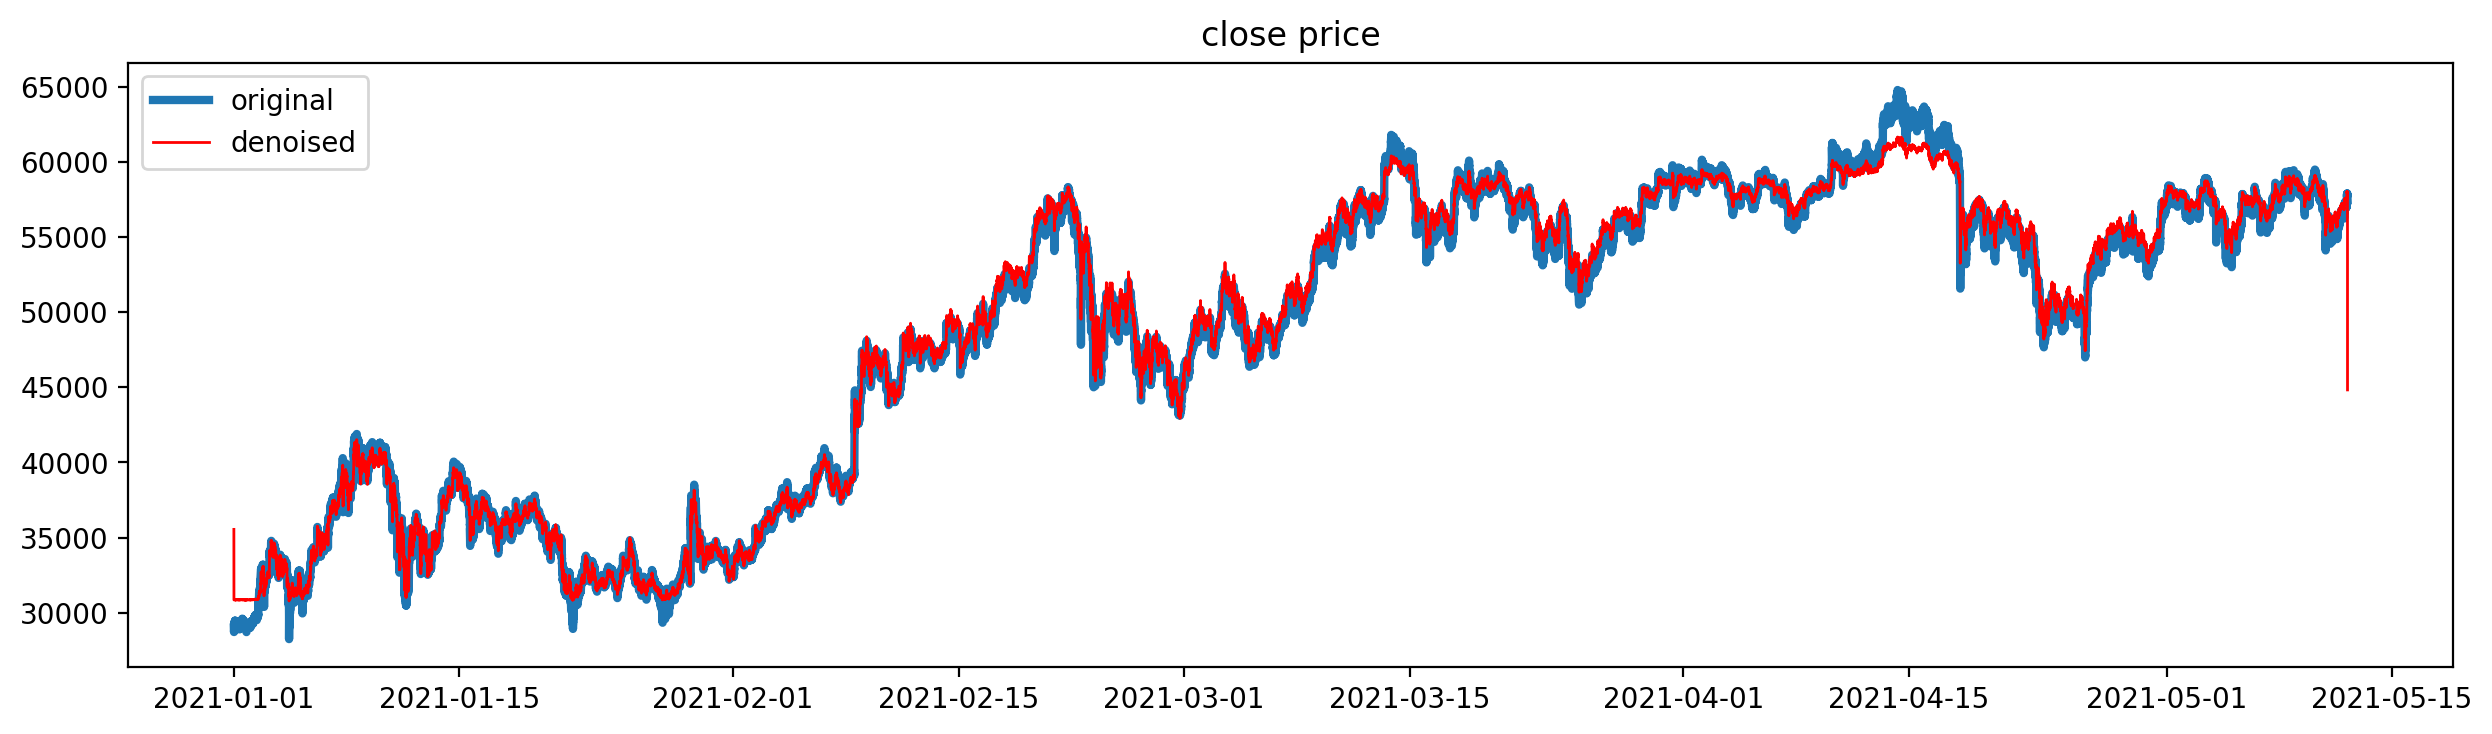

In [126]:
mm_tb = MinMaxScaler()
noise_mm_Tb=mm_tb.fit_transform(bit_test)
Y_test_mm_cnnb = modelen_mmb.predict(noise_mm_Tb.T)
Y_test_mm_cnnb=Y_test_mm_cnnb.reshape((len(bit_test),1))
pure_mm_cnnb = mm_tb.inverse_transform(Y_test_mm_cnnb)
pure_mm_cnnb=pd.DataFrame(pure_mm_cnnb,columns=['Close'],index=bit_test.index)
plt.figure(figsize=(15,4),dpi=200)
plt.plot(bit_test,linewidth=3,label='original')
plt.plot(pure_mm_cnnb,'r',linewidth=1,label='denoised')
plt.title('close price')
plt.legend(loc='upper left')

## Models' prediction

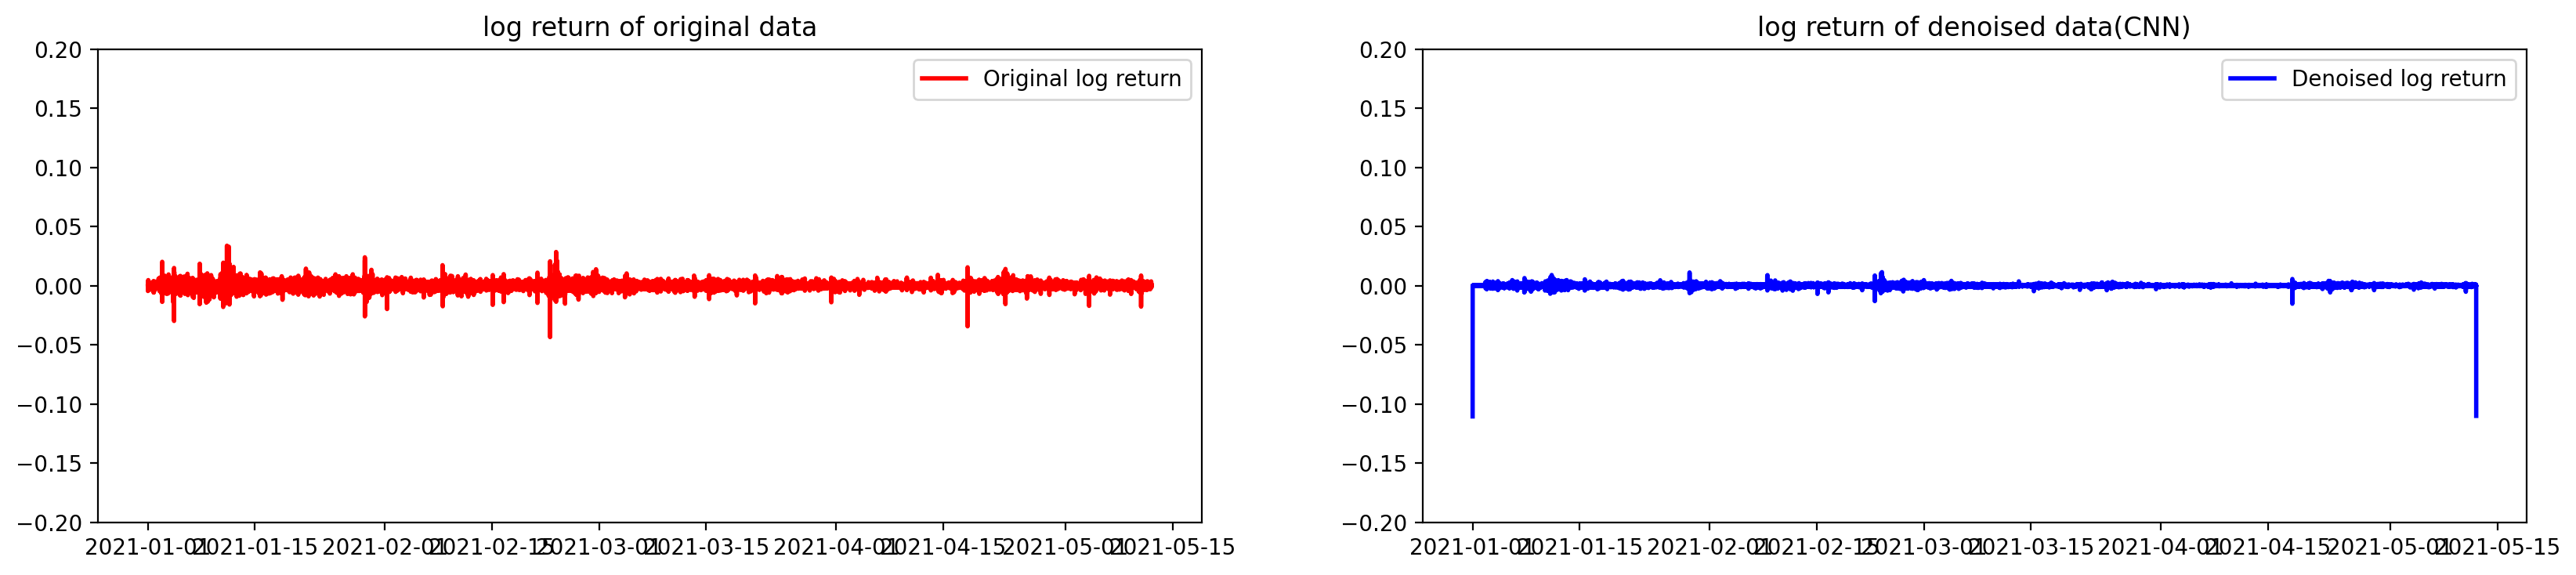

In [127]:
# Log Returns
bit_test_n=bit_test.copy()
bit_test_n['log_ret'] = np.log(bit_test.iloc[:,0]).diff()
#pure_mm_lstm['log_ret'] = np.log(pure_mm_lstm.iloc[:,0]).diff()
pure_mm_cnnb['log_ret'] = np.log(pure_mm_cnnb.iloc[:,0]).diff()


plt.figure(figsize=(20,4),dpi=200)
plt.subplot(1,2,1)
plt.plot(bit_test_n['log_ret'], 'r-', linewidth=2, label='Original log return')
plt.ylim(-0.2,0.2)
plt.title('log return of original data')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(pure_mm_cnnb['log_ret'] , 'b-', linewidth=2, label='Denoised log return')
plt.ylim(-0.2,0.2)
plt.title('log return of denoised data(CNN)')
plt.legend(loc='best')

# plt.subplot(1,3,3)
# plt.plot(pure_mm_lstm['log_ret'], 'y-', linewidth=2, label='Denoised log return')
# plt.ylim(-0.2,0.2)
# plt.title('log return of denoised data(LSTM)')
# plt.legend(loc='best')

plt.show()

## SVM

In [128]:
import warnings
warnings.filterwarnings("ignore")
#warnings.filterwarnings("default")

In [129]:
def svmf1(dataset,dataset2,long_predict=10):
    f1=np.empty(0)
    f12=np.empty(0)
    max_t=0
    if dataset['log_ret'].max()>dataset2['log_ret'].max():
        max_t=dataset['log_ret'].max()
    else:
        max_t=dataset2['log_ret'].max()
    for n in np.arange(0.0, 0.5*max_t,  0.5*max_t/50):#get multiple threshold
        threshold = n
        # for dataset
        daily_label=np.empty(0)#make the data labelled
        for i in range(0,len(dataset)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label=np.append(daily_label,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label=np.append(daily_label,n)
            else:
                n=1
                daily_label=np.append(daily_label,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        f1=np.append(f1,cross_val_score(svc_rbf , X_train, Y_train, scoring='f1_micro',cv=2,error_score=1).mean())
        
        # for dataset2
        daily_label2=np.empty(0)#make the data labelled
        for i in range(0,len(dataset2)):
            if dataset2.iloc[i,1]<-threshold:
                n=-1
                daily_label2=np.append(daily_label2,n)
            elif abs(dataset2.iloc[i,1])<=threshold:
                n=0
                daily_label2=np.append(daily_label2,n)
            else:
                n=1
                daily_label2=np.append(daily_label2,n)
        X2=pd.DataFrame()
        Y2=pd.DataFrame()
        for i in range(1,len(dataset2)-long_predict):
            X2=pd.concat([X2, pd.DataFrame(dataset2.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y2=pd.concat([Y2, pd.DataFrame(daily_label2[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X2=np.array(X2)
        Y2=np.array(Y2[0])
        X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, Y2, test_size=0.2,random_state=1)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        f12=np.append(f12,cross_val_score(svc_rbf , X_train2, Y_train2, scoring='f1_micro',cv=2,error_score=1).mean())
    return f1,f12

In [ ]:
original_svmb,denoised_svmb=svmf1(bit_test_n,pure_mm_cnnb)

In [ ]:
plt.figure(figsize=(20,6))
max_t=0
if bit_test_n['log_ret'].max()>pure_mm_cnnb['log_ret'].max():
    max_t=bit_test_n['log_ret'].max()
else:
    max_t=pure_mm_cnnb['log_ret'].max()
plt.plot(np.arange(0.0, 0.5*max_t,  0.5*max_t/50),original_svmb,label='orignal_svm', color='red', linewidth=2.0)
plt.plot(np.arange(0.0, 0.5*max_t,  0.5*max_t/50),denoised_svmb,label='denoised_svm', color='blue', linewidth=4.0, linestyle='--')

plt.xticks(np.arange(0.0,0.5*max_t, 0.5*max_t/6))
plt.xlabel('threshold')
plt.ylabel('f1_value')
plt.legend()